In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [13]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(start, stop, text,labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False, highlight=None, row=0, showP6=False):
    
    
    models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_p_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    #p7v6_LL_total = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    #p7v6_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike_nodm.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):        
        
            
        h = h5py.File('../mod_c/'+model)

        fit = h['/fit_results/GC'].attrs
        fit_no_dm = h['/fit_results/GC_no_dm'].attrs
        #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
        ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
        ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))

        fit_global = h['/fit_results/global'].attrs
        llg1.append(-fit_global['localfval'])
        #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
        llg2.append(-fit_global['outerfval'])
        llg3.append(-fit_global['innerfval'])
        llg4.append(llg1[-1]+llg2[-1]+llg3[-1])

        #print fit.keys()
        E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']

        plt.subplot(1,3,1+3*row)


        E_p6, spec_p6, spec_unc_p6 = pickle.load(open('../p6v11_Analysis_spectrum.pickle','rb'))

        if i==0:
#             plt.errorbar(E_p6/1e3,E_p6**2*spec_p6/1e3,([E_p6**2,E**2]*spec_unc_p6.T/1e3), 
#                          label='P6V11',capthick=1, capsize=2, ls=':', marker='o', markersize=2)
            plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3, 
                         label='ModA',capthick=1, capsize=2, ls=':', marker='o', markersize=2)

        elif i%mod==0:

            if highlight is not None and i == highlight:
                plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3, 
                             label=labels[i-1],capthick=1, capsize=2, ls='-', marker='o', markersize=2)
            else:
                plt.errorbar(E/1e3,(E**2*flux/1e3), 
                             label=labels[i-1],capthick=1, capsize=2, ls='-' )

    
    plt.subplot(1,3,1+3*row)
    plt.legend(frameon=False, fontsize=8, labelspacing=.2, borderpad=0.1)
    plt.yscale('log')
    plt.xscale('log')
    
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    
    if row==2:
        plt.xlabel(r'$\rm{E\ [GeV]}$')
    
    
    plt.ylim(5e-8,2e-6)
    plt.text(.03,.8, text, transform=plt.gca().transAxes, fontsize=10)
    
            
    plt.subplot(1,3,2+3*row)
    fh2 = range(0,len(ll)-1)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
    
    
    print len(fh2), len(ll)
    plt.plot(fh2, ll[1:],marker='o',ls=':',color='firebrick', label='With DM',markersize=4)
    plt.plot(fh2, ll_no_dm[1:],marker='o',ls='--',color='steelblue',label='No DM',markersize=4)
    plt.xlim(-.5, len(ll)-1.5)
    plt.xticks(range(len(labels)), labels, rotation='vertical')
    

    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    
    if showP6:
        #plt.hlines(p7v6_LL_total, -1, len(labels), color='firebrick')
        plt.hlines(p6v11_LL_total, -1, len(labels), color='firebrick',linestyles=':')
        #plt.hlines(p7v6_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--')
        plt.hlines(p6v11_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--' )
        plt.text(-.01*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total+.025*(plt.ylim()[1]-plt.ylim()[0]),'P6V11', color='firebrick', fontsize=8)
        #plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6', color='purple', fontsize=8)

        plt.text(-.01*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total_no_dm-.07*(plt.ylim()[1]-plt.ylim()[0]),'P6V11 No DM', color='steelblue', fontsize=8)
        #plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total_no_dm-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6 No DM', color='purple', fontsize=8)
               
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    if start < 28:
        plt.legend(frameon=False, fontsize=8, loc=4, bbox_to_anchor=(.95, .15))
    else:
        plt.legend(frameon=False, fontsize=8, loc=1, ncol=2)
    
    plt.subplot(1,3,3+3*row)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    
    
    plt.plot(fh2, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(fh2, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(fh2, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(fh2, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    plt.xticks(range(len(labels)), labels, rotation='vertical')
    plt.xlim(-.5, len(ll)-1.5)
    if row==2:
        plt.xlabel(r'$f_{\rm H2}$', fontsize=12)
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=9, ncol=4, columnspacing=.5)
    
    





# PEB HI+H2.
##Default Model is $v_a=35$ km/s, $D_0=7.2e28$, $f_{sprl}=.2$, SNR source dist, $z_{max}=3.$ kpc, $T_s=150$, Mag5

9 10


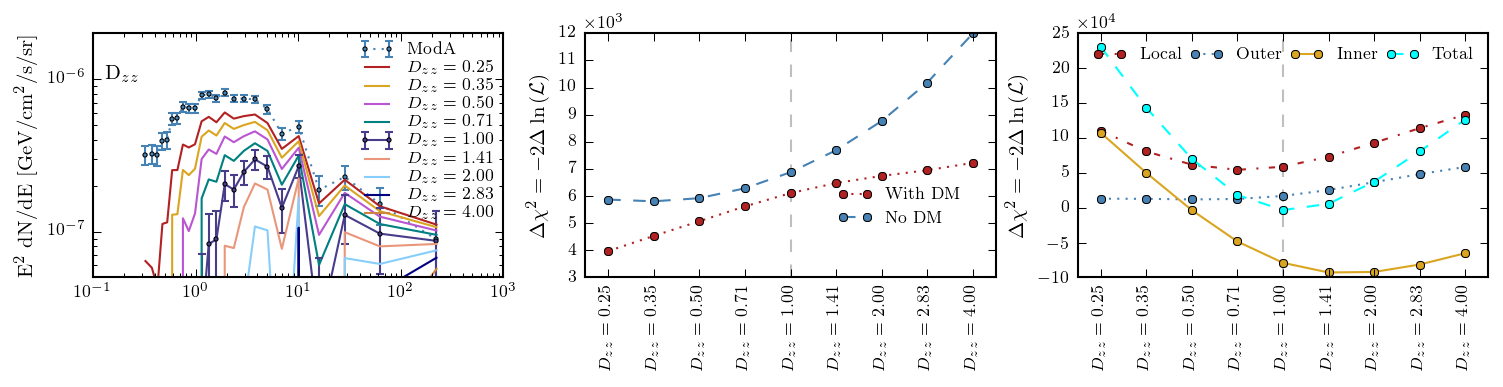

13 14


/home/carlson/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


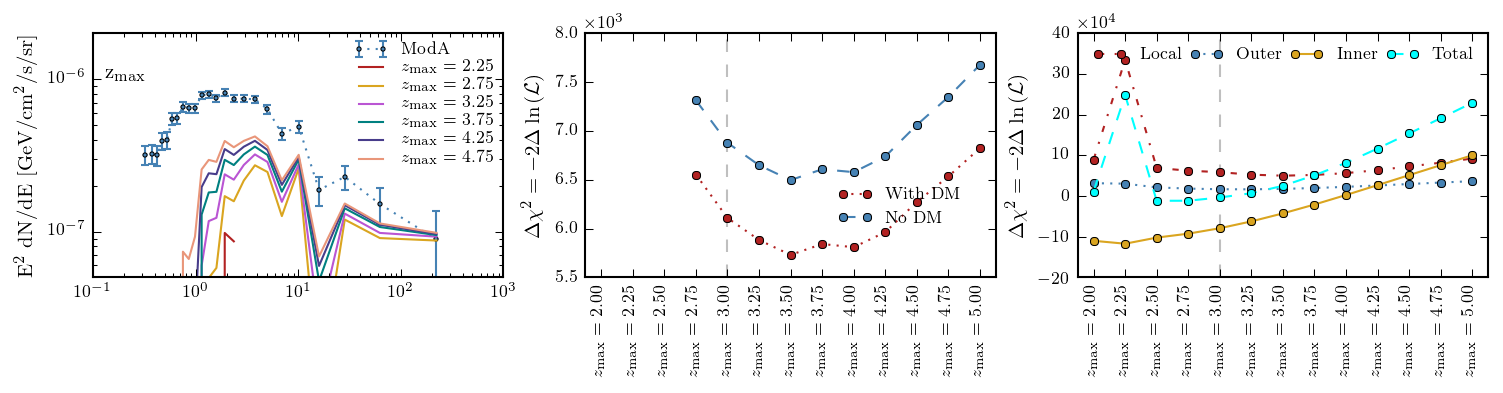

4 5


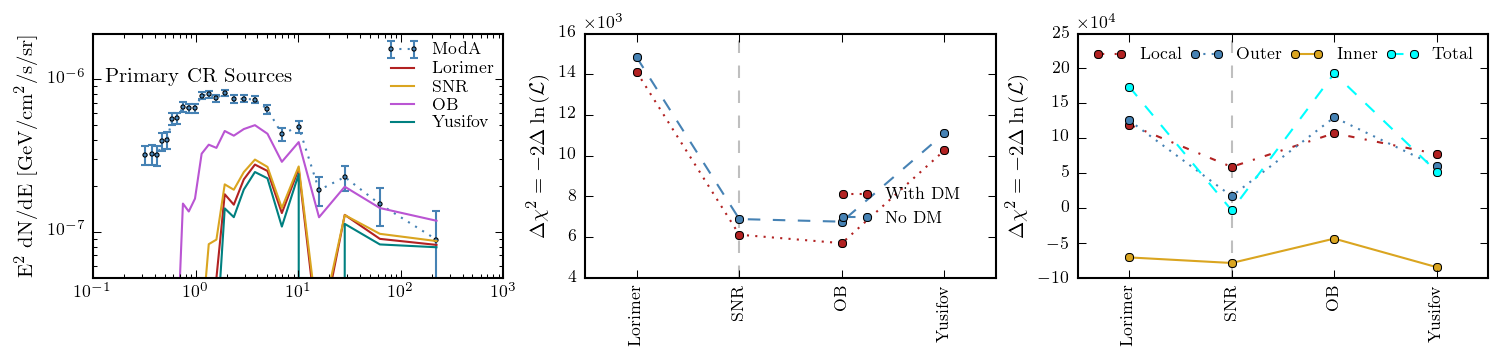

4 5


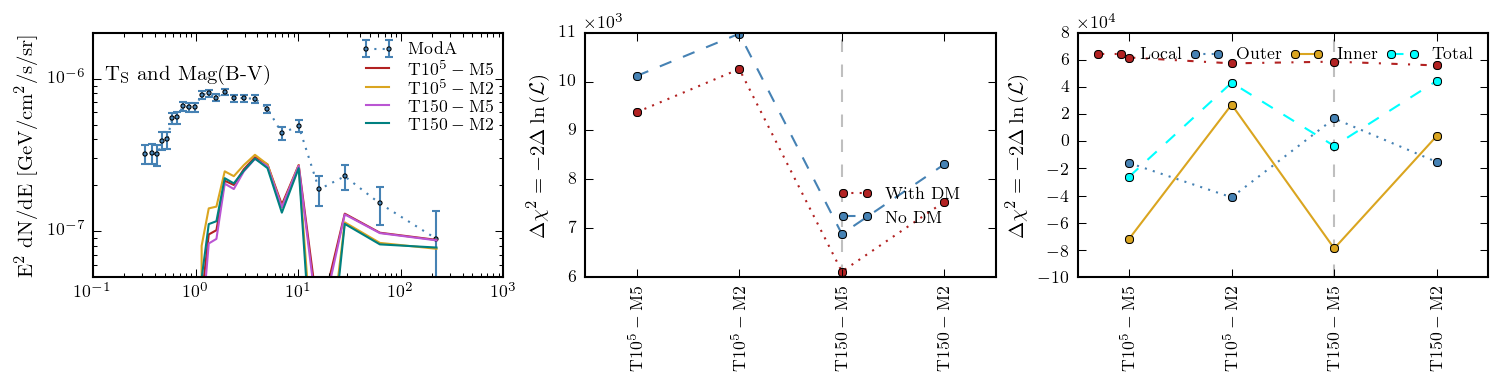

11 12


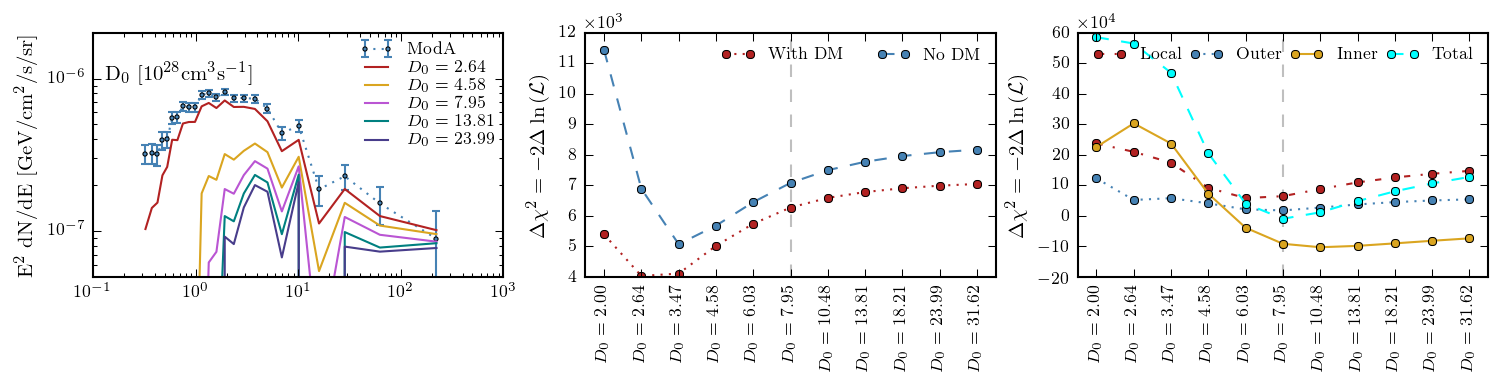

8 9


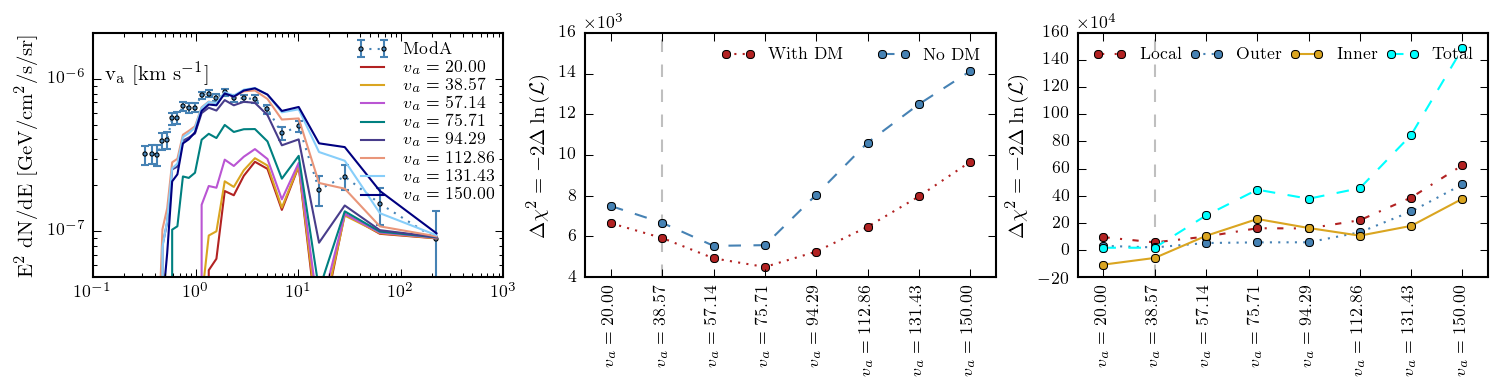

In [14]:
plt.figure(figsize=(12,2.1))
PlotSeries(start=0, stop=9, text='D_{zz}', labels=[r'$D_{zz}=%1.2f$'%i for i in np.logspace(np.log10(.25), np.log10(4), 9)], mod=1, line=4, highlight=5)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=9, stop=22, text=r'z_{\rm max}', labels=[r'$z_{\rm max}=%1.2f$'%i for i in np.linspace(2,5,13)], mod=2, line=4)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=22, stop=26, text='Primary CR Sources', labels=('Lorimer','SNR','OB','Yusifov'), line=1, ylim_glob=(None, 25e4))
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=26, stop=30, text=r'$\rm T_S$ and Mag(B-V)', labels=(r'$\rm T10^5-M5$',r'$\rm T10^5-M2$',r'$\rm T150-M5$',r'$\rm T150-M2$'), line=2, ylim_glob=(-10e4, None))
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=30, stop=41, text=r'$\rm D_0\ [10^{28} cm^{3}s^{-1}]$', labels=['$D_0=%2.2f' % D + '$' for D in np.logspace(np.log10(2e28),29.5,11)/1e28], mod=2, line=5)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=41, stop=49, text=r'$\rm v_a\ [km\ s^{-1}]$', labels=['$v_a=%2.2f' % D + '$' for D in np.linspace(20,150,8)], mod=1, line=1)
plt.show()


# Galrop HI, galprop H2.   

9 10


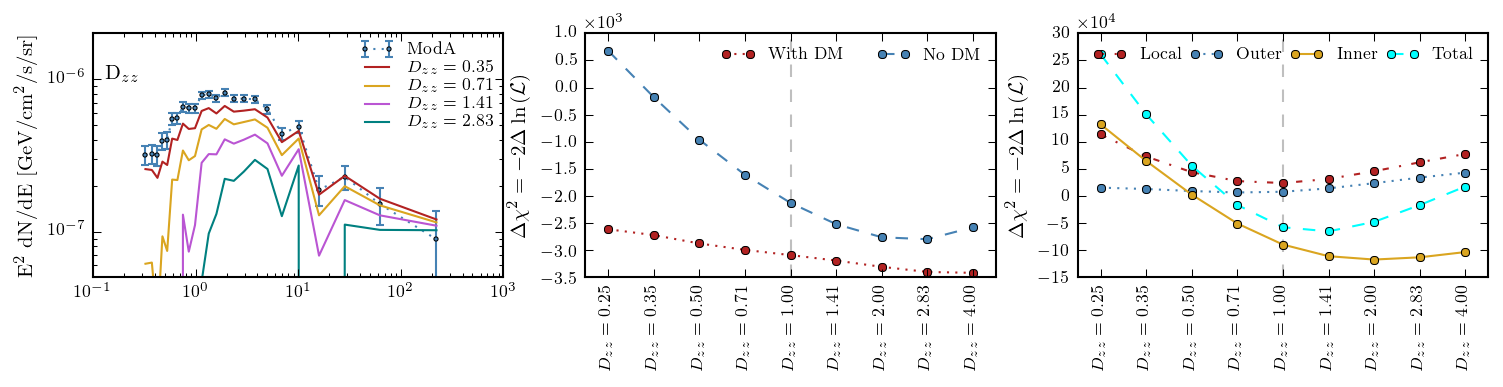

13 14


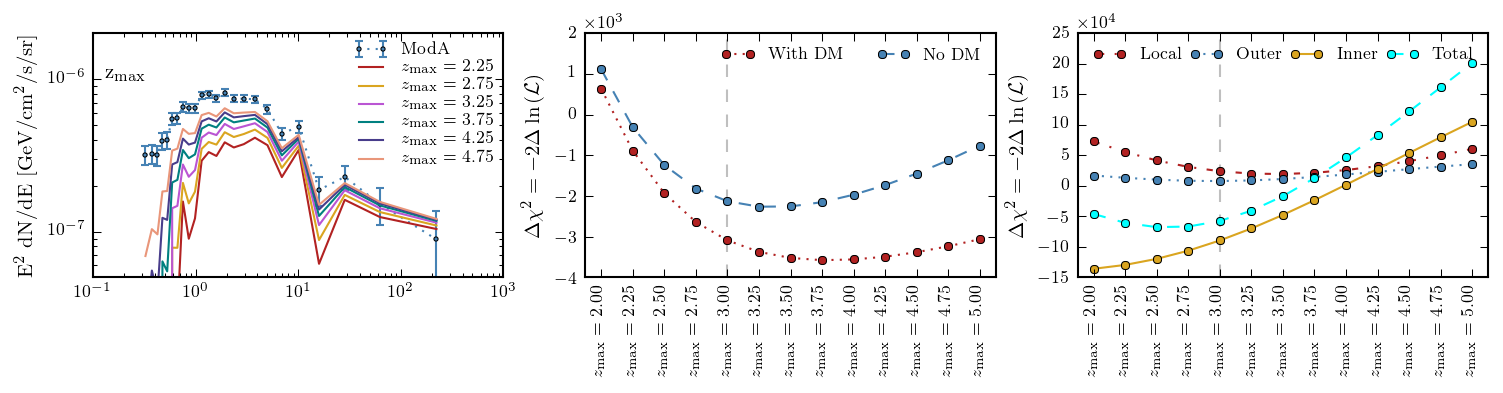

4 5


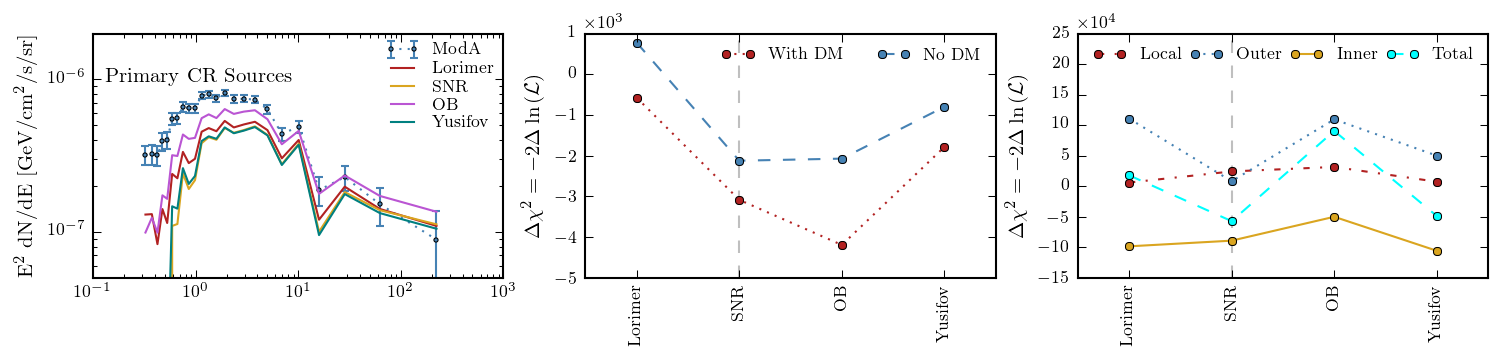

4 5


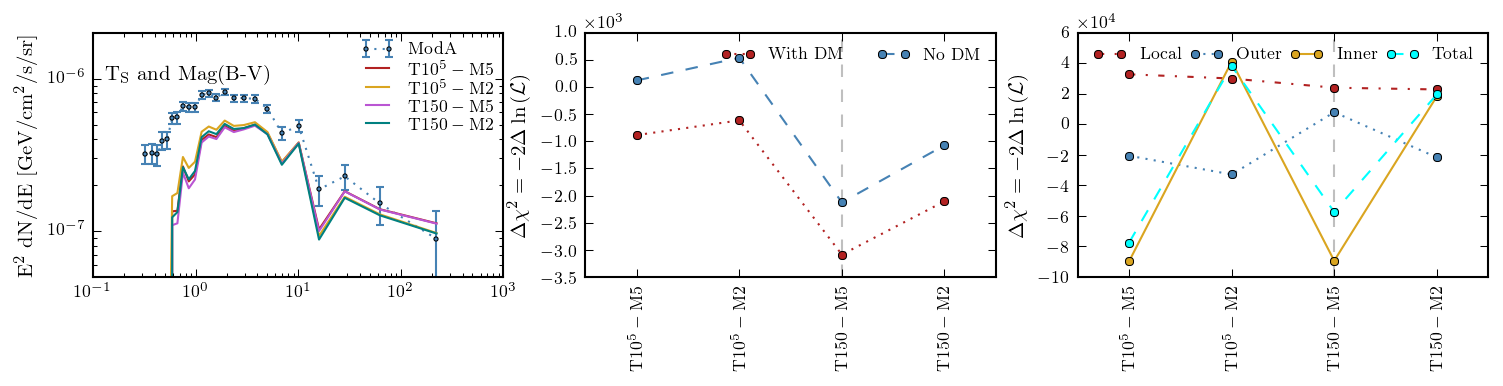

11 12


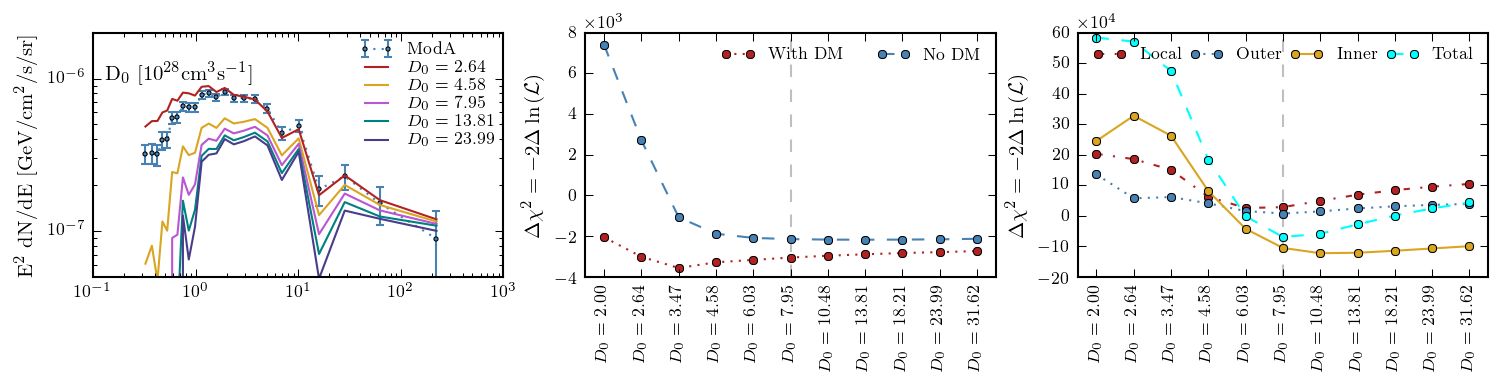

8 9


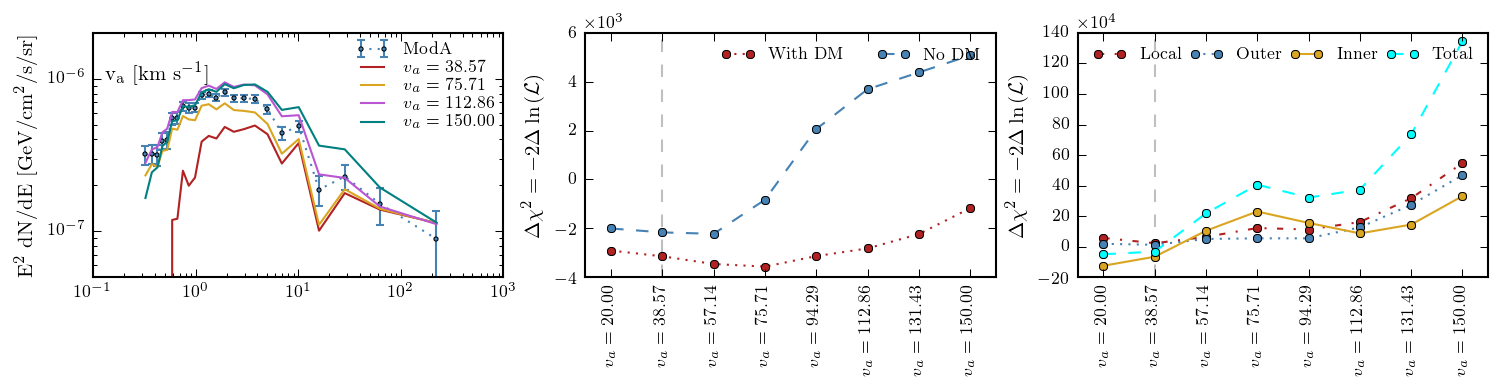

In [15]:
plt.figure(figsize=(12,2.1))
PlotSeries(start=0+49, stop=9+49, text='D_{zz}', labels=[r'$D_{zz}=%1.2f$'%i for i in np.logspace(np.log10(.25), np.log10(4), 9)], mod=2, line=4, highlight=5)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=9+49, stop=22+49, text=r'z_{\rm max}', labels=[r'$z_{\rm max}=%1.2f$'%i for i in np.linspace(2,5,13)], mod=2, line=4)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=22+49, stop=26+49, text='Primary CR Sources', labels=('Lorimer','SNR','OB','Yusifov'), line=1, ylim_glob=(None, 25e4))
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=26+49, stop=30+49, text=r'$\rm T_S$ and Mag(B-V)', labels=(r'$\rm T10^5-M5$',r'$\rm T10^5-M2$',r'$\rm T150-M5$',r'$\rm T150-M2$'), line=2, ylim_glob=(-10e4, None))
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=30+49, stop=41+49, text=r'$\rm D_0\ [10^{28} cm^{3}s^{-1}]$', labels=['$D_0=%2.2f' % D + '$' for D in np.logspace(np.log10(2e28),29.5,11)/1e28], mod=2, line=5)
plt.show()
plt.figure(figsize=(12,2.1))
PlotSeries(start=41+49, stop=49+49, text=r'$\rm v_a\ [km\ s^{-1}]$', labels=['$v_a=%2.2f' % D + '$' for D in np.linspace(20,150,8)], mod=2, line=1)
plt.show()


# XCO Variation as $f_{H2}$ is increased


mod_o_14_XCO_P8_stripped.hdf5
[0.99214279651641846, 2.4978797435760498, 3.5009911060333252, 4.4933414459228516, 5.7537765502929688, 7.2556867599487305, 8.9999980926513672, 13.25, 33.25]
[523049971334899.06, 3.8287200433079963e+20, 2.1143425913434276e+20, 1.3853520002760611e+20, 1.2996781250857481e+20, 8.0923280559516582e+19, 4.0738542878296105e+19, 1.4230605646183836e+19, 1.9730367036008733e+21]

mod_o_15_XCO_P8_stripped.hdf5
[0.99214279651641846, 2.4978797435760498, 3.5009911060333252, 4.4933414459228516, 5.7537765502929688, 7.2556867599487305, 8.9999980926513672, 13.25, 33.25]
[2236640650465.9155, 2.4978696315869708e+20, 1.9930268806779837e+20, 1.1701438244206774e+20, 1.2104599298403195e+20, 7.6035912266567467e+19, 4.0733056048480346e+19, 1.4502835649520263e+19, 2.0431128763865031e+21]

mod_o_16_XCO_P8_stripped.hdf5
[0.99214279651641846, 2.4978797435760498, 3.5009911060333252, 4.4933414459228516, 5.7537765502929688, 7.2556867599487305, 8.9999980926513672, 13.25, 33.25]
[736024929892

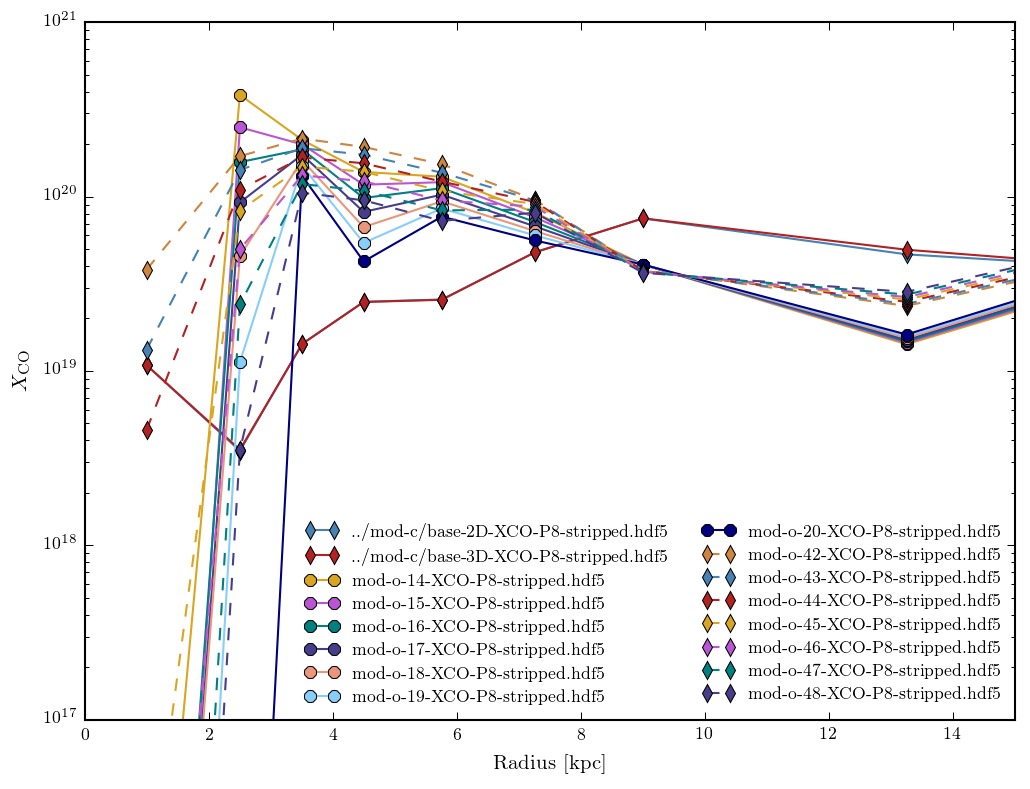

In [6]:
import h5py
import pyfits
h = pyfits.open('/data/galprop2/FITS/rbands_co10mm_v2_2001_qdeg_9R_new.fits.gz')
rings = [.5*(r1+r2) for r1,r2 in h[1].data]



X_CO_values = [6.2560429788495372e+19, 3.4680211758611346e+20, 5.5591619439658749e+20, 3.4376189911339867e+20, 3.151243723689986e+20, 2.6276239270686782e+20, 6.6356248035046998e+19, 1.9567428895977403e+21, 6.8600341256635098e+22]
X_CO_radius = [0.99214279651641846, 2.4978797435760498, 3.5009911060333252, 4.4933414459228516, 5.7537765502929688, 7.2556867599487305, 8.9999980926513672, 13.25, 33.25]
X_CO_interp = lambda x: 10**np.interp(np.log10(x), np.log10(X_CO_radius), np.log10(X_CO_values))


def X_CO_MS04(R):
    fX_CO_= 0.4E20  
    if (R> 3.5): fX_CO_= 0.6E20
    elif (R> 5.5): fX_CO_= 0.8E20
    elif (R> 7.5): fX_CO_= 1.5E20
    elif (R> 9.5): fX_CO_=10.0E20
    return fX_CO_

MS04_xco = np.array([X_CO_MS04(r) for r in rings])

def PlotSeries(start, stop, text, ylim=None, mod=1):
    
    models = ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    
    for i, model in enumerate(models):
        if (i%mod)==0:
            h = h5py.File('../mod_c/'+model)
            
            fit_global = h['/fit_results/global'].attrs
            #vals = X_CO_interp(rings)*fit_global['global_XCO']
            vals = MS04_xco*fit_global['global_XCO']
            if start > 28: 
                plt.plot(rings, vals, label=model.replace('_','-'), marker='d', linestyle='--')
            else:
                plt.plot(rings, vals, label=model.replace('_','-'), marker='o', linestyle='-')
            
            print 
            print model
            print rings
            print list(vals)
    
def PlotBase():
    
    models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5', '../mod_c/base_3D_XCO_P8_stripped.hdf5'] 
    
    for i, model in enumerate(models):
 
        #try:
            h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5', 'r')
            h = h5py.File('../mod_c/'+model)

            fit_global = h['/fit_results/global'].attrs
            #vals = X_CO_interp(rings)*fit_global['global_XCO']
            vals = MS04_xco*fit_global['global_XCO']
            plt.plot(rings, vals, label=model.replace('_','-'), marker='d')
            

        #except: pass

plt.figure(figsize=(8,6))
PlotBase()
PlotSeries(14,21,'xco',mod=1)
PlotSeries(42,49,'xco',mod=1)
plt.xlabel('Radius [kpc]')
plt.ylabel(r'$X_{\rm CO}$')
plt.legend(loc=4, frameon=False, ncol=2, fontsize=8)
plt.xlim(0,15)
plt.ylim(1e17,1e21)
plt.yscale('log')







# Longitudinal Variations of DM center

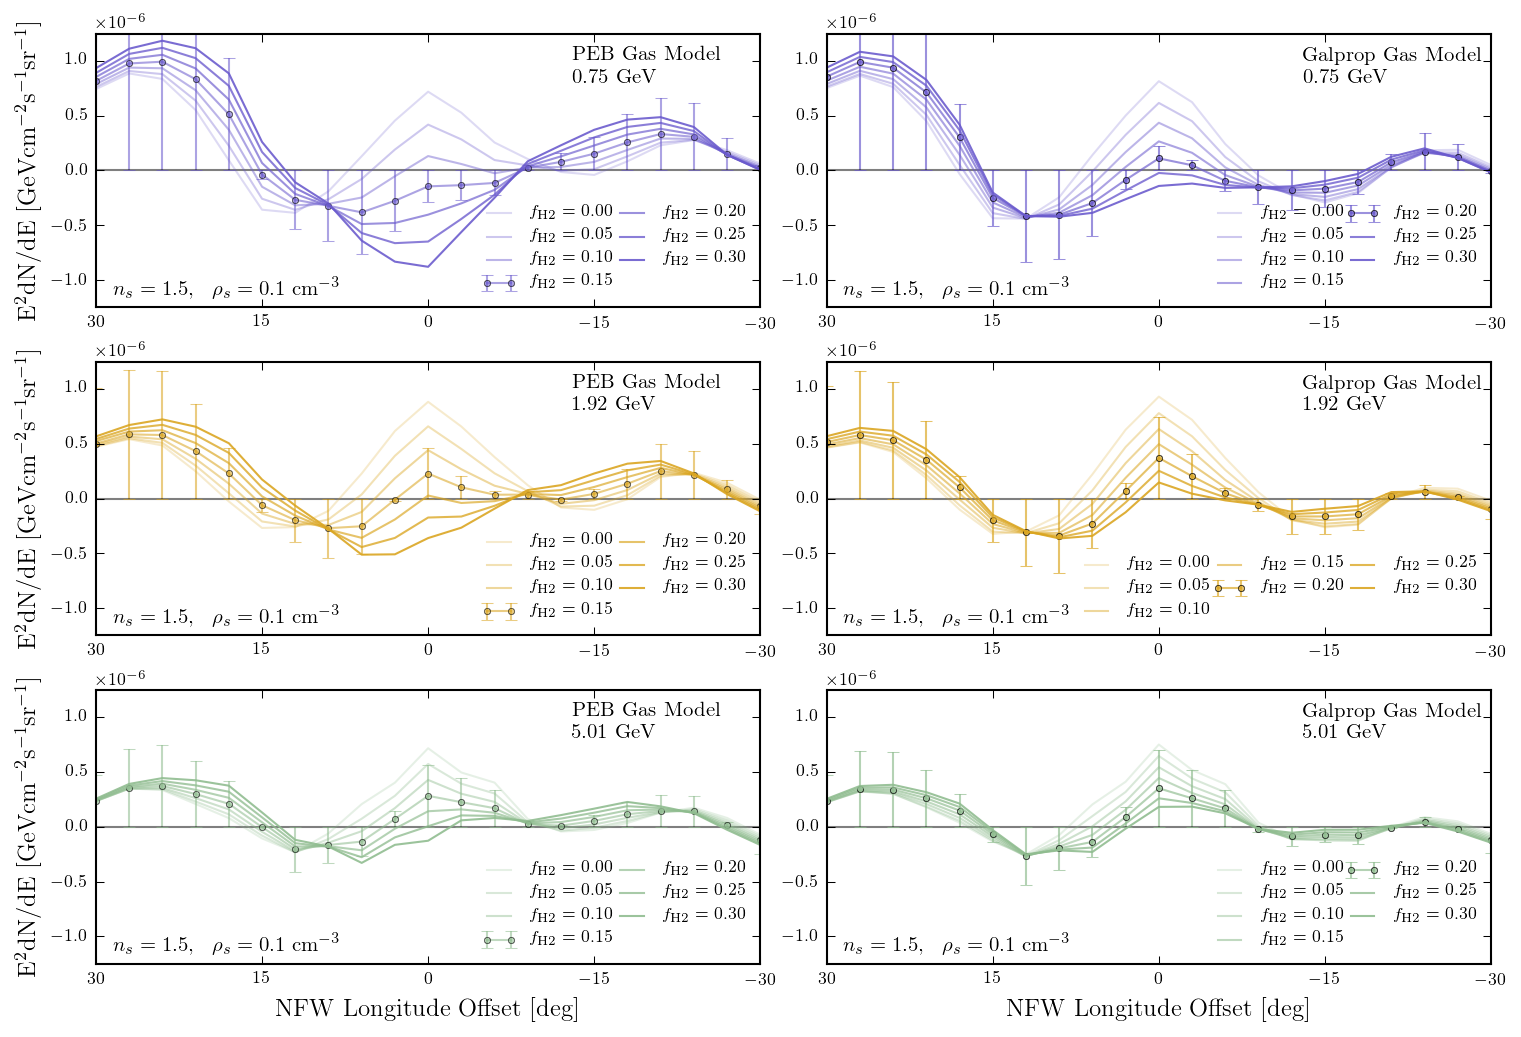

In [17]:
count = 0
import h5py

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag



def PlotRange(start, stop, energy, c, alpha=None,label=None, text=None):
    for i in range(start,stop):
        h5 = h5py.File('../mod_c/mod_o_'+str(i)+'_XCO_P8_stripped.hdf5', 'r')
        
        energies =  h5['/fit_results/scan_longitude/'].attrs['energies']
        
        dm_spec =  h5['/fit_results/scan_longitude/'].attrs['dm_spec']
        
        dm_spec_unc =  h5['/fit_results/scan_longitude/'].attrs['dm_spec_unc']
        lons =  h5['/fit_results/scan_longitude/'].attrs['longitudes']

        ebin = np.argmin(np.abs(energy-energies))

        flux = [energies[ebin]**2*spec[ebin]/1e3 for spec in dm_spec]
        flux_unc = [energies[ebin]**2*spec_unc[ebin]/1e3 for spec_unc in dm_spec_unc]

        ls = '-'

        if i in [17,46]:
            #ls = '--'
            plt.errorbar(lons,flux, flux_unc, color=c, alpha=(i-start+2)/(stop-start+2.), ls=ls, label=label[i-start], marker='o',markersize=3,)
        else:
            plt.errorbar(lons,flux, color=c, alpha=(i-start+2)/(stop-start+2.), ls=ls, label=label[i-start])

    

    plt.legend(frameon=False, ncol=2, loc=4,fontsize=8, columnspacing=.2)
    plt.ylabel(r'$\rm E^2 dN/dE$ [$\rm GeV cm^{-2} s^{-1} sr^{-1}$]', fontsize=12)
    plt.xlabel(r'NFW Longitude Offset [deg]', fontsize=12)
    plt.ylim(-12.5e-7, 12.5e-7)
    
    plt.text(.025,.035, r'$n_s=1.5, \ \ \rho_s=0.1\ {\rm cm^{-3}}$', transform=plt.gca().transAxes, fontsize=10)
    
    if energy>8e3:
        plt.ylim(-12.5e-7/2, 12.5e-7/2)
        if text is not None:
            plt.text(-13, .80e-6/2, '%1.2f GeV'%(energies[ebin]/1e3), fontsize=10)
            plt.text(-13,.1e-6/2, text, fontsize=10)
            
    else:
        if text is not None:
            plt.text(-13,.8e-6, '%1.2f GeV'%(energies[ebin]/1e3), fontsize=10)
            plt.text(-13,1e-6, text, fontsize=10)
            
            
    plt.hlines(0,-100,100, alpha=0.5)
    plt.gca().set_xticks(np.linspace(-90,90,13))
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(-6))
    plt.xlim(30, -30)
    
    
plt.figure(figsize=(12,8.))
plt.subplot(321)
PlotRange(14,21, energy=.75e3, c='slateblue', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='PEB Gas Model')
plt.xlabel('')
plt.subplot(323)
PlotRange(14,21, energy=2e3, c='goldenrod', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='PEB Gas Model')    
plt.xlabel('')
plt.subplot(325)
PlotRange(14,21, energy=5e3, c='darkseagreen', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='PEB Gas Model')    
#plt.show()

#plt.figure(figsize=(20,10))
plt.subplot(322)
PlotRange(42,49, energy=.75e3, c='slateblue', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='Galprop Gas Model')
plt.ylabel('')
plt.xlabel('')
plt.subplot(324)
PlotRange(42,49, energy=2e3, c='goldenrod', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='Galprop Gas Model')    
plt.legend(frameon=False, ncol=3, loc=4,fontsize=8, columnspacing=.2)
plt.ylabel('')
plt.xlabel('')
plt.subplot(326)
PlotRange(42,49, energy=5e3, c='darkseagreen', alpha=None,label=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], text='Galprop Gas Model')    
plt.ylabel('')


plt.subplots_adjust(wspace=0.1)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/scan_lon_flux_P8.pdf', bbox_inches='tight')

In [47]:
import h5py
def PlotAxesRatio(start,stop):
    for i in range(start, stop):
        if i%1==0:
            h5 = h5py.File('../mod_c/mod_o_'+str(i)+'_XCO_P8_stripped.hdf5', 'r')
            
            ll =  h5['/fit_results/scan_axesratio/'].attrs['loglike_total']
            ar =  h5['/fit_results/scan_axesratio/'].attrs['axesratio']
            plt.plot(ar,2*(ll-min(ll)), label='mod %i'%i)

    plt.ylabel(r'$2\Delta\log{(\mathcal{L})}$')
    plt.xlabel(r'Axes Ratio')
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,2e2)
    
    
def PlotAxesRatioSpectrum(start, stop):
    for i in range(start, stop):
        if i%1==0:
            h5 = h5py.File('../mod_c/mod_o_'+str(i)+'_XCO_P8_stripped.hdf5', 'r')
            ar =  h5['/fit_results/scan_axesratio/'].attrs['axesratio']
            flux =  h5['/fit_results/scan_axesratio/'].attrs['flux_DM']
            energies =  h5['/fit_results/scan_axesratio/'].attrs['energies']
            
            for i_f, f in enumerate(flux):
                plt.plot(energies/1e3,energies**2*f/1e3)#, label=str(ar[i_f]))
            plt.xscale('log')
            plt.yscale('log')

    plt.ylabel(r'$2\Delta\log{(\mathcal{L})}$')
    plt.xlabel(r'E')
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(-1e-6,1e-5)

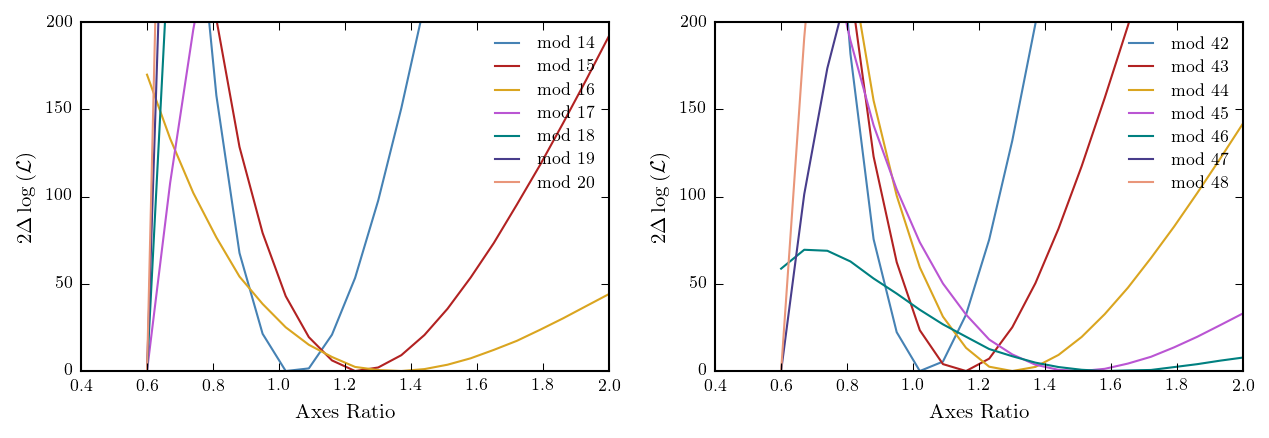

In [48]:
plt.figure(figsize=(10,3))
plt.subplot(121)
PlotAxesRatio(14,21)
plt.subplot(122)
PlotAxesRatio(42,49)

In [15]:
import h5py
from mpl_toolkits.axes_grid1 import AxesGrid

def PlotLocalize(start, stop):
    fig = plt.figure(figsize=(10,10))

    grid = AxesGrid(fig, 111, # similar to subplot(142)
                        nrows_ncols = (4, 3),
                        axes_pad = 0.0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode="single",)

    for i in range(start,stop):
        k=i-start
        
        #plt.subplot(3,4,i+1)
        h5 = h5py.File('../mod_c/mod_k_'+str(i)+'_XCO_stripped.hdf5', 'r')
        #for f in h5['/fit_results/']:
            #print f  
        ll =  h5['/fit_results/localize/'].attrs['fval']
        ar =  h5['/fit_results/localize/'].attrs['longitudes']

        im = grid[k].imshow(2*(ll-np.min(ll)) ,vmin=0, vmax=200, origin='lower', extent=[min(ar),max(ar),min(ar),max(ar)],
                            interpolation='nearest',cmap='gnuplot')


    


        label = [r'$f_{\rm H2}=%1.2f$'%j for j in np.linspace(0,.5,11)]

        #plt.colorbar(im, label=(r'$2\Delta\log{(\mathcal{L})}$'))
        grid[k].text(.25,-.90, label[k], fontsize=8)
        if i in [0,3,6,9]:
            grid[k].set_ylabel(r'$b$ [deg]')
        if i in [9,10]:
            grid[k].set_xlabel(r'$l$ [deg]')
        #plt.show()

    grid.cbar_axes[0].colorbar(im)
    for cax in grid.cbar_axes[1:]:
            cax.toggle_label(False)

    grid.cbar_axes[0].set_ylabel(r'$2\Delta\log{(\mathcal{L})}$') 



# Localization of DM template in inner galaxy analysis for PEB Models

# Localization of DM template in inner galaxy analysis for Galprop Models

# Same as above, but paper version with fewer panels

In [18]:
import cPickle as pickle
import h5py

def PlotSpec(start, stop,labels, keys, ylim, colors, dm=True):
    
    #models = ['../mod_c/base_2D_XCO_stripped.hdf5'] + ['mod_k_%i_XCO_stripped.hdf5'%i for i in range(start, stop)]
    models = ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    
    for i, model in enumerate(models):
        if i%1==0:
            h = h5py.File('../mod_c/'+model)
            if dm is True:
                fit = h['/fit_results/GC'].attrs
            else:
                fit = h['/fit_results/GC_no_dm'].attrs
            #print fit.keys()
            
            for j, key in enumerate(keys):
                lab = None
                if i == 6:
                    lab = key.replace('flux_',"").replace('_','+')
                if (i == 3 and start<28) or (i==4 and start>27):
                    plt.errorbar(fit['energies']/1e3, fit['energies']**2*fit[key]/1e3, fit['energies']**2*fit[key.replace('flux','fluxunc')][:,1]/1e3 ,
                                 label=lab,alpha=(i+3)/(stop-start+3.), color=colors[j], marker='o', markersize=2, markeredgecolor=None)
                else:
                    plt.loglog(fit['energies']/1e3, fit['energies']**2*fit[key]/1e3,label=lab,alpha=(i+3)/(stop-start+3.), c=colors[j])
                    
    if start<28:
        plt.text(.37,.93, 'PEB Gas', transform=plt.gca().transAxes, fontsize=10)
        
    else: 
        plt.text(.37,.93, 'Galprop Gas', transform=plt.gca().transAxes, fontsize=10)
        
    if dm==True:
        plt.text(.37,.87, 'With NFW', transform=plt.gca().transAxes, fontsize=10)
    else: 
        plt.text(.37,.87, 'No NFW', transform=plt.gca().transAxes, fontsize=10)
    #fit_no_dm = h['/fit_results/GC_no_dm'].attrs
    
    
    plt.legend(frameon=False, fontsize=10, ncol=1)        
            
    plt.ylim(ylim)
    plt.xlim(3e-1,2.5e2)
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    

#Varying f_H2 (light to dark is increasing f_H2 0.0 - 0.5 in .1 increments
## With DM included in the fit

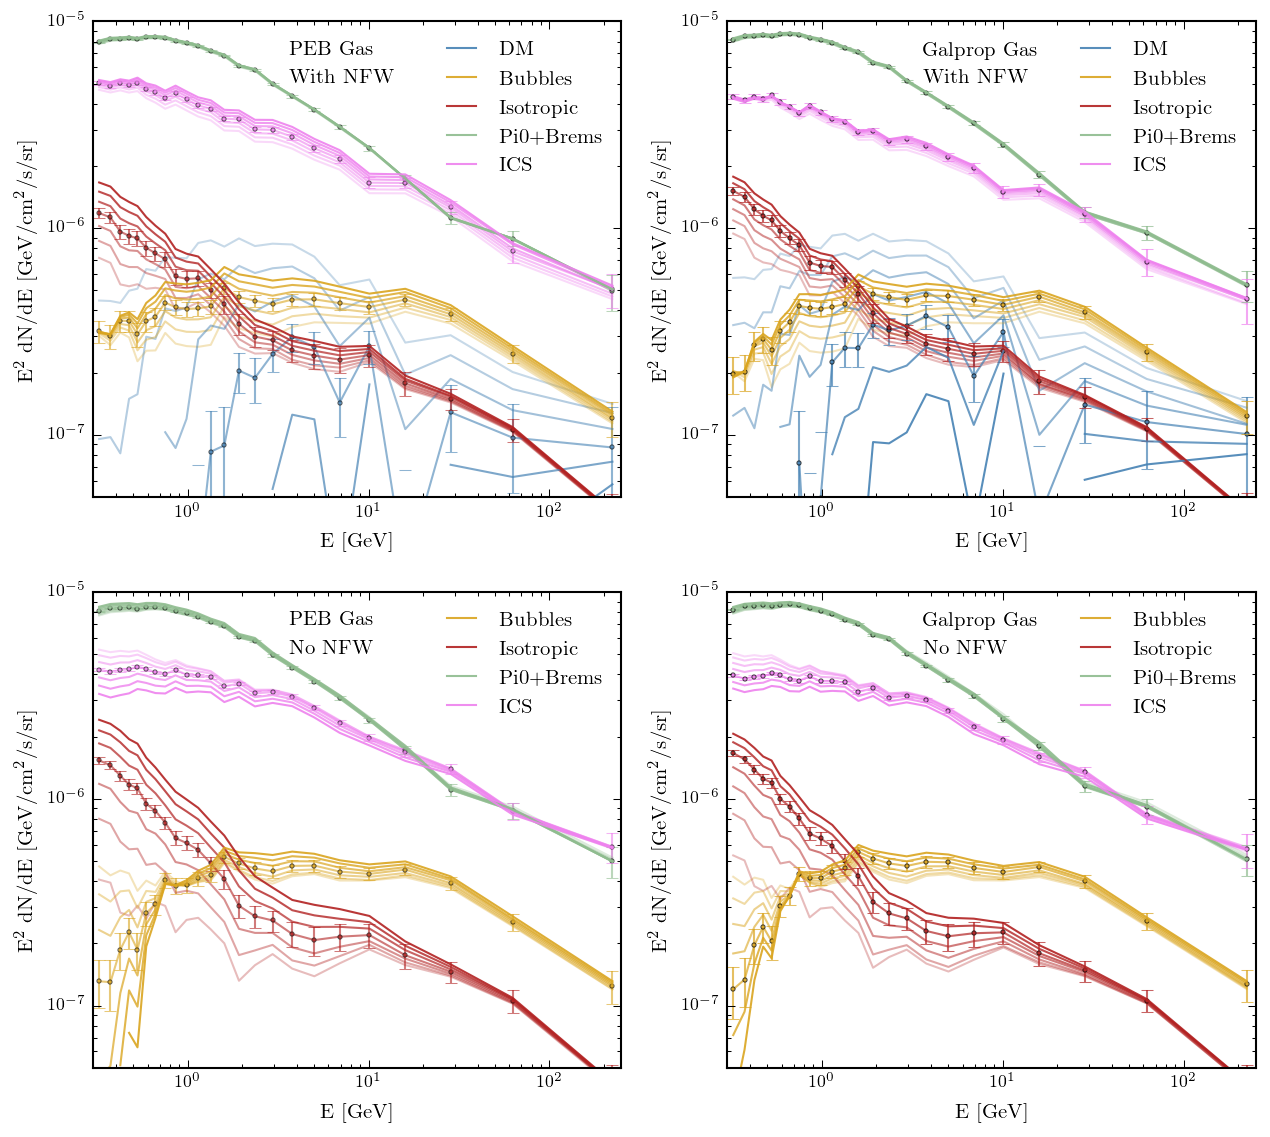

In [19]:


plt.figure(figsize=(10,9))

components = ['flux_DM', 'flux_Bubbles', 'flux_Isotropic',u'flux_Pi0_Brems', u'flux_ICS']
colors = ['steelblue','goldenrod','firebrick', 'darkseagreen','violet']


plt.subplot(2, 2, 1)

PlotSpec(14,21,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors)

# plt.yscale('symlog', linthreshy=1e-6)
# plt.grid(axis='y', which='both')
# plt.ylim(-1e-6,1e-5)
# plt.fill_between((.01,1e3), (-5e-7, -5e-7), (5e-7,5e-7), color='b', alpha=.05 )
# plt.hlines(0,1e-3,1e5, alpha=.5, color='k')

plt.subplot(2, 2, 2)
PlotSpec(42,49,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors)
components = [ 'flux_Bubbles', 'flux_Isotropic',u'flux_Pi0_Brems', u'flux_ICS']
colors = ['goldenrod','firebrick', 'darkseagreen','violet']

plt.subplot(2, 2, 3)
PlotSpec(14,21,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors, dm=False)
plt.subplot(2, 2, 4)
PlotSpec(42,49,labels=[r'f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors, dm=False)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/spectral_plots_P8.pdf', bbox_inches='tight')

# Same as above, but with symlog for fits including GCE

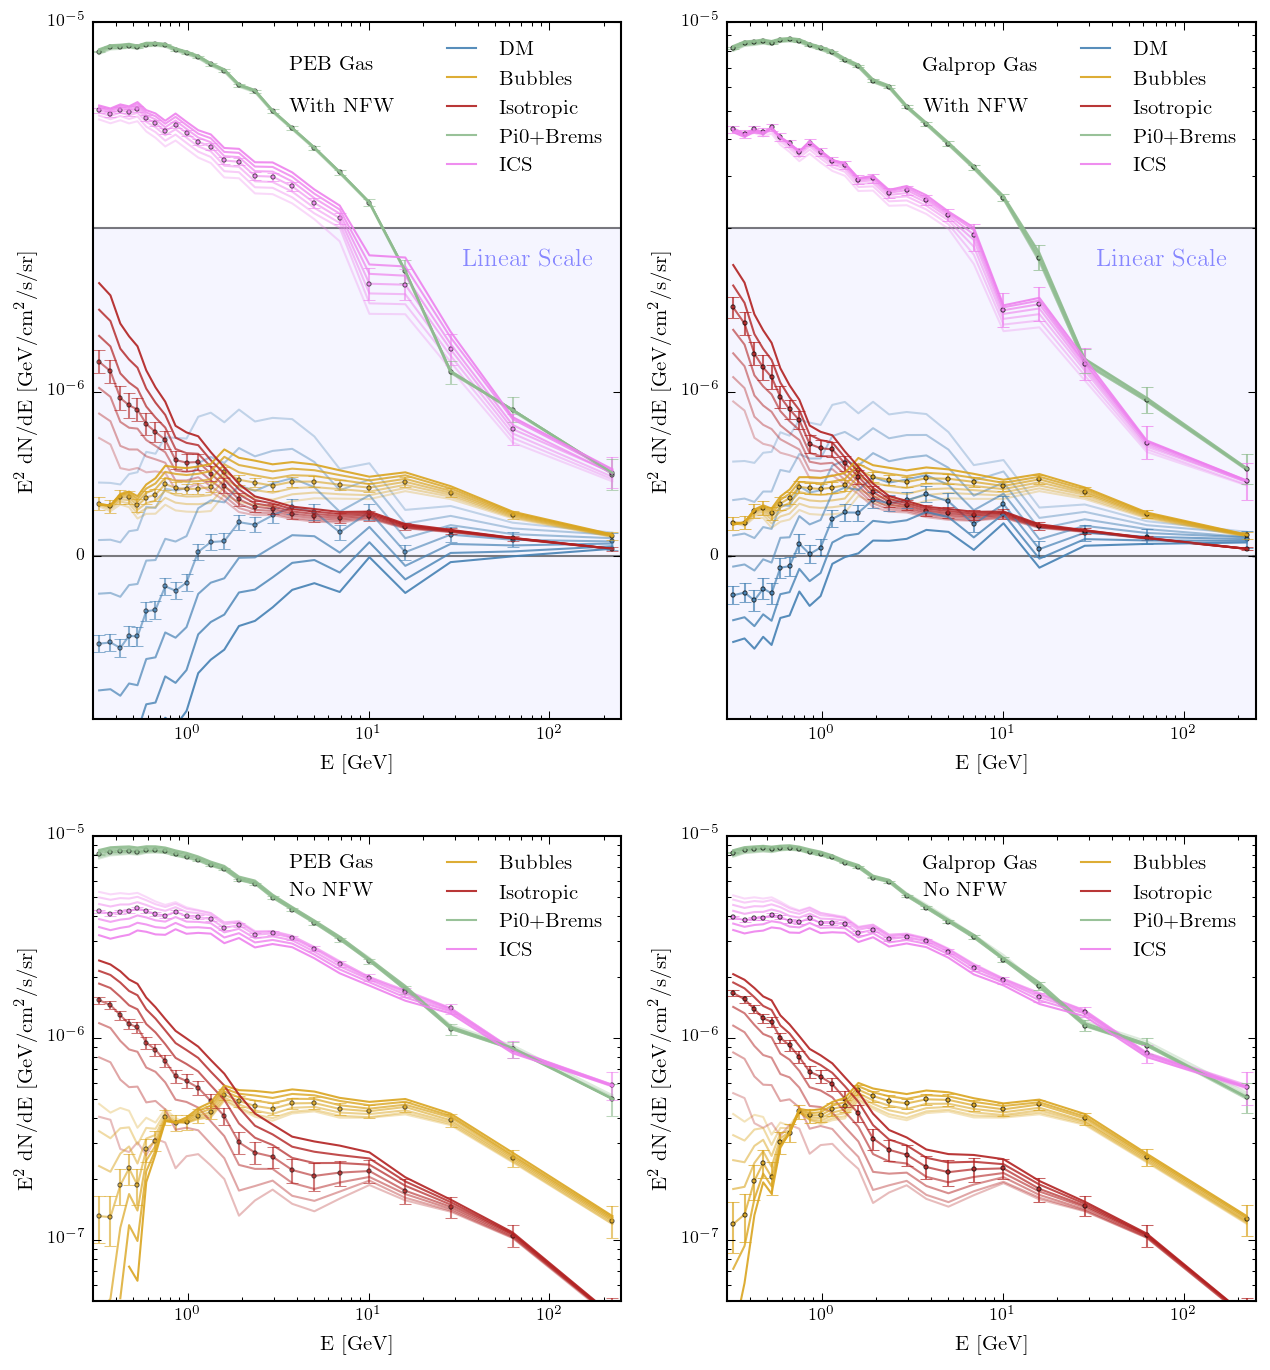

In [20]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1.5,1])

plt.figure(figsize=(10,11))

components = ['flux_DM', 'flux_Bubbles', 'flux_Isotropic',u'flux_Pi0_Brems', u'flux_ICS']
colors = ['steelblue','goldenrod','firebrick', 'darkseagreen','violet']


plt.subplot(gs[0,0])

PlotSpec(14,21,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors)

linthresh = 2e-6

plt.yscale('symlog', linthreshy=linthresh)
#plt.grid(axis='y', which='both')
plt.ylim(-1e-6,1e-5)
plt.fill_between((.01,1e3), (-linthresh, -linthresh), (linthresh,linthresh), color='b', alpha=.04 )
plt.hlines((-linthresh,0, linthresh),1e-3,1e5, alpha=.5, color='k')
plt.text(.7, .65, 'Linear Scale', color='b', transform=plt.gca().transAxes, alpha=.45)

plt.subplot(gs[0,1])
PlotSpec(42,49,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors)

plt.yscale('symlog', linthreshy=linthresh, subsy=np.arange(0,10))
plt.ylim(-1e-6,1e-5)
plt.fill_between((.01,1e3), (-linthresh, -linthresh), (linthresh,linthresh), color='b', alpha=.04 )
plt.hlines((-linthresh,0, linthresh),1e-3,1e5, alpha=.5, color='k')
plt.text(.7, .65, 'Linear Scale', color='b', transform=plt.gca().transAxes, alpha=.45)



components = [ 'flux_Bubbles', 'flux_Isotropic',u'flux_Pi0_Brems', u'flux_ICS']
colors = ['goldenrod','firebrick', 'darkseagreen','violet']

plt.subplot(gs[1,0])
PlotSpec(14,21,labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors, dm=False)
plt.subplot(gs[1,1])
PlotSpec(42,49,labels=[r'f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.5,11)], keys=components, ylim=(5e-8,1e-5), colors=colors, dm=False)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/spectral_plots_semilogy_P8.pdf', bbox_inches='tight')

# Scanning Inner Slope: Profile flattens out with increasing spiral fraction and is already flatter in new gas models.

# Radial profiles for several energies

/home/carlson/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


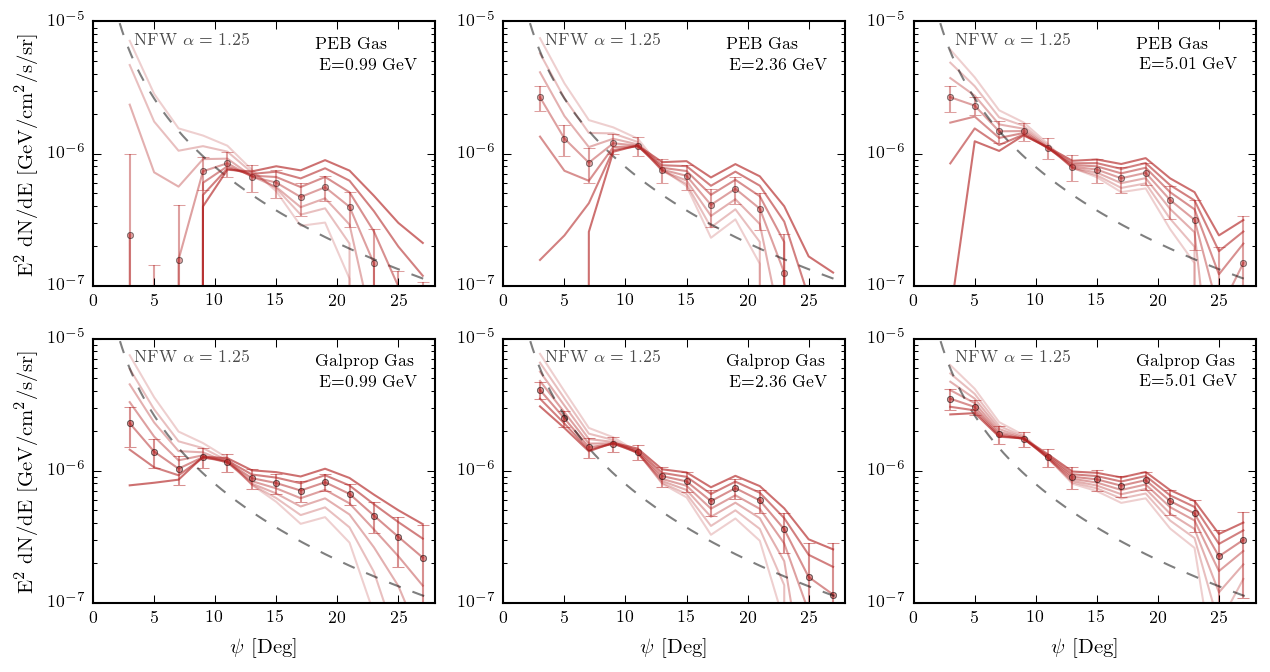

In [ ]:
import cPickle as pickle
import h5py
import sys
sys.path.append('/data/GCE_sys/')
import Analysis

# Load the DM profile flux for a gamma=1.25 
radius_, flux_ = pickle.load(open('../DM_radial_profile_alph_1.25.pickle', 'rb'))

def PlotRadial(start, stop, energy, text, labels=None):
    
    A = Analysis.Analysis(nside=256)
    npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
    area_ratios = None
    
    models = ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    
    for i, model in enumerate(models):
        if i%1==0:
            h = h5py.File('../mod_c/'+model)
            fit = h['/fit_results/scan_radius'].attrs
            avR = [.5*(r1+r2) for r1, r2 in fit['radius']]
            
            E = fit['energies']
            
            # Find closest energy
            E_bin = np.argmin(np.abs(energy-E))
            
            if area_ratios is None:
                area_ratios = [npix_roi/float(np.nonzero(A.GenRadialMask(r1,r2,plane_mask=2.)*A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]) for r1, r2 in fit['radius']]
            
            radial_prof = [area_ratios[i_r]*E[E_bin]**2/1e3*fit['flux_ring_%i'%i_r][E_bin] for i_r in range(len(avR))]
            radial_prof_unc = np.array([area_ratios[i_r]*E[E_bin]**2/1e3*fit['fluxunc_ring_%i'%i_r][E_bin] for i_r in range(len(avR))]).T
            
            label=None
            if labels is not None:
                label=labels[i]
            
            
            if (i == 3 and start<28) or (i==4 and start>27):
                plt.errorbar(avR, radial_prof, radial_prof_unc, color='firebrick', alpha=(i+3)/14., marker='o',markersize=3, label=label)
                plt.plot(radius_, flux_*2.5e-30 ,color='k',alpha=.5,ls='--')
                plt.text(radius_[27],flux_[25]*3e-30 ,r'NFW $\alpha=1.25$',color='k',fontsize=8, alpha=.7)
                plt.xlim(0,28)
            else:
                                
                plt.errorbar(avR, radial_prof, color='firebrick', alpha=(i+3)/14., label=label)
            

    
    
    
    
    plt.text(.65, .9,text, transform=plt.gca().transAxes, fontsize=8, color='k')    
    plt.ylim(1e-7,1e-5)
    plt.text(.66,.82, r'E=%1.2f GeV'%(E[E_bin]/1e3),transform=plt.gca().transAxes, fontsize=8, color='k')
#     if energy>1.5e3:
#         plt.text(.04, .04, r'Light to Dark: $f_{\rm H2} \in [0,0.3,\Delta=.05]$',transform=plt.gca().transAxes, fontsize=8, color='firebrick')
    plt.yscale('log')
    
    
    
plt.figure(figsize=(10,5))
plt.subplot(231)
plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
PlotRadial(14, 21, 1e3, text='PEB Gas')
plt.subplot(232)
PlotRadial(14, 21, 2.5e3, text='PEB Gas')
plt.subplot(233)
PlotRadial(14, 21, 5e3, text='PEB Gas')


plt.subplot(234)
plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
plt.xlabel(r'$\rm{\psi\ [Deg]}$')
PlotRadial(42, 49, 1e3, text='Galprop Gas')
plt.subplot(235)
PlotRadial(42, 49, 2.5e3, text='Galprop Gas')
plt.xlabel(r'$\rm{\psi\ [Deg]}$')
plt.legend(frameon=False, fontsize=8, ncol=2,loc=3 )        
plt.subplot(236)
PlotRadial(42, 49, 5e3, text='Galprop Gas', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)])
plt.xlabel(r'$\rm{\psi\ [Deg]}$')

plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/radial_plots_P8.pdf', bbox_inches='tight')

   # Quadrants Radial Variation

In [ ]:
import cPickle as pickle
import h5py
import sys
sys.path.append('/data/GCE_sys/')
import Analysis

# Load the DM profile flux for a gamma=1.25 
radius_, flux_ = pickle.load(open('../DM_radial_profile_alph_1.25.pickle', 'rb'))

quadrants = [['E', -45, 45], ['N', 45, 135], ['W', 135, 225], ['S', 225, 315]]


A = Analysis.Analysis(nside=256)
npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
square_mask = A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2)

def GetQuadrant(model, quadrant):
    # Open the file and load the fit results of interest.
    h = h5py.File('../mod_c/mod_o_%i_XCO_P8_stripped.hdf5'%model)
    fit = h['/fit_results/quadrants'].attrs
    avR = [.5*(r1+r2) for r1, r2 in fit['radius']]
    
    # Find closest energy.
    E = fit['energies']
    
    area_ratios = None
    
    for quad, start_angle, stop_angle in quadrants:
        if quad is not quadrant: 
            continue
        
        if area_ratios is None:
            # Calculate the ratio of each ring/quadrant to the total ROI in order to rescale the flux.
            area_ratios = [npix_roi/float(np.nonzero(A.GenRadialMask(r1,r2,plane_mask=2.,start_angle=start_angle, stop_angle=stop_angle)
                                                     *square_mask)[0].shape[0]) for r1, r2 in fit['radius']]
        
        # Read out the flux of each radial bin
        radial_prof = np.array([area_ratios[i_r]*E**2/1e3*fit['flux_ring_%i'%i_r+'_'+quad] for i_r in range(len(avR))])
        radial_prof_unc = np.array([area_ratios[i_r]*E**2/1e3*fit['fluxunc_ring_%i'%i_r+'_'+quad][:,1] for i_r in range(len(avR))])
    return avR, radial_prof, radial_prof_unc, E/1e3
        
        


def GetAllQuadrants(start, stop):
    '''
    returns a list [E,N,W,S] where E contains a list of [radius, flux, fluxunc] for each model.
    '''
    
    E = [GetQuadrant(i,'E') for i in range(start,stop)]
    N = [GetQuadrant(i,'N') for i in range(start,stop)]
    W = [GetQuadrant(i,'W') for i in range(start,stop)]
    S = [GetQuadrant(i,'S') for i in range(start,stop)]
    return E, N, W, S

E, N, W, S = GetAllQuadrants(0, 11)
E_gal, N_gal, W_gal, S_gal = GetAllQuadrants(43, 54)

#Spectrum as a function of radius (highest energy bin excluded from fits as it is problematically converging)

In [ ]:
import cPickle as pickle
import h5py
import sys
sys.path.append('/data/GCE_sys/')
import Analysis

import warnings
warnings.filterwarnings("ignore")

import iminuit 
import h5py


def BPLSpec(E, norm, index1, index2, E_break):
    return norm*5e-9*   np.piecewise(E, ((E<E_break), (E>=E_break)), (lambda E: (E/E_break)**-index1, lambda E: (E/E_break)**-index2))
    

def FitSpectrumBPL(E, flux, fluxunc, index1=None, index2=None, E_break=None, print_level=1):
    '''
    Fit a broken-power-law spectrum to the input data.
    
    :params E: energies corresponding to flux
    :params flux: flux of spectrum
    :params fluxunc: uncertainty on flux (single gaussian value)
    :params index1: Low energy spectral index. if None, float, otherwise fix to specified value
    :params index2: High energy spectral index. if None, float, otherwise fix to specified value
    :params E_break: Break energy in units of the input spectrum.
    '''
    
    # If fit didn't converge, errors are zero. Make them infinite here instead so the points don't bias fits.
#     fluxunc2 = fluxunc.copy()
#     print flux, fluxunc
#     fluxunc2[flux < 0] = 1e10
#     print fluxunc2/flux
    
    def f(norm, index1, index2, E_break):
        '''Calculate chisq'''
        model = BPLSpec(E, norm, index1, index2, E_break)        
        chisq = np.sum( (flux-model)**2/fluxunc**2 )
        return np.log(chisq)
            
    E_break_val=2.
    E_break_fixed = False
    if E_break is not None:
        E_break_val = E_break
        E_break_fixed=True
        
    index1_val=2
    index1_fixed = False
    if index1 is not None:
        index1_val = index1
        index1_fixed=True
    
    index2_val=3
    index2_fixed = False
    if index2 is not None:
        index2_val = index2
        index2_fixed=True
    
    
    m = iminuit.Minuit( f, print_level=print_level, index1=index1_val, norm=1., index2=index2_val, E_break=E_break_val, errordef=1., 
                        error_norm=.5, error_E_break=.1, error_index1=.1, error_index2=.1,
                        limit_index1=[0,None],  limit_norm=[0,None],  limit_index2=[0,None], limit_E_break=[0,None],
                      fix_E_break=E_break_fixed, fix_index1=index1_fixed, fix_index2=index2_fixed)
    m.migrad()
    try: 
        m.minos()
    except: 
        m.hesse()
    reduced_chisq = m.fval/(len(flux)-4-1) # 4 params, reduced chisq

    return m, reduced_chisq



def PlotRadialSpectra(start, stop, text):
    
    A = Analysis.Analysis(nside=256)
    npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
    area_ratios = None
    
    models = ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    
    for i, model in enumerate(models):
        if i%1==0:
            h = h5py.File('../mod_c/'+model)
            fit = h['/fit_results/scan_radius'].attrs
            avR = [.5*(r1+r2) for r1, r2 in fit['radius']]
            
            E = fit['energies']
            
            # Find closest energy
            #E_bin = np.argmin(np.abs(energy-E))
            
            if area_ratios is None:
                area_ratios = [npix_roi/float(np.nonzero(A.GenRadialMask(r1,r2,plane_mask=2.)*A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]) for r1, r2 in fit['radius']]
            
            radial_prof = [area_ratios[i_r]*E**2/1e3*fit['flux_ring_%i'%i_r] for i_r in range(len(avR))]
            radial_prof_unc = np.array([area_ratios[i_r]*E**2/1e3*fit['fluxunc_ring_%i'%i_r][:,1] for i_r in range(len(avR))])
            
            
            for i_r,r in enumerate(avR):
                
                if r >23:
                    continue
                
                plt.subplot(6,3,i_r+1)
                if (i == 3 and start<28) or (i==4 and start>27):
                    plt.yscale('log')
                    plt.xscale('log')
                    plt.ylim(5e-8, 1e-5)
                    plt.xlim(3e-1,1e2)
                    plt.text(.75, .88, r'$\psi=%1.1f$ deg'%r, transform=plt.gca().transAxes, fontsize=8, color='k')    
                    plt.text(.75, .79,text, transform=plt.gca().transAxes, fontsize=8, color='k')    
                    
                    if i_r+1 in [1,4,7,10]:
                        plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$', fontsize=11)
                    if (i_r+1) > 9:
                        plt.xlabel(r'$\rm{E\ [GeV]}$', fontsize=11)
                    plt.errorbar(E/1e3, radial_prof[i_r], radial_prof_unc[i_r,], color='firebrick', alpha=(i+3)/10., marker='o',markersize=3)
                    

                    # ------------------------------------------------------------
                    # FITTING THE SPECTRUM 
                    fit_E = E[:-1]/1e3
                    flux = radial_prof[i_r][:-1]/(fit_E**2*1e3)
                    fluxunc = radial_prof_unc[i_r][:-1]/(fit_E**2*1e3)

                    bad_bins = []
                    for i_f, fu in enumerate(fluxunc):
                        if fu==0:
                            fluxunc[i_f] = 1e50
                            bad_bins.append(i_f)

                    m, reduced_chisq = FitSpectrumBPL(fit_E, flux, fluxunc, print_level=0)
                    for i in bad_bins: 
                        fluxunc[i] = 0
                    
                    x_lab, y_lab = 0.05, 0.25
                    if r>14:
                        y_lab += .65
                    model = BPLSpec(E/1e3,**m.values)
                    plt.loglog(E/1e3, E**2/1e3*model, color='k',ls='--')
                    #plt.errorbar(E,E**2*flux,E**2*fluxunc.T)
                    E_br = m.values['E_break']
                    #print m.get_merrors().keys(), (m.get_merrors()['E_break'].lower, m.get_merrors()['E_break'].upper)
                    #print (np.abs(m.get_merrors()['E_break'].lower), m.get_merrors()['E_break'].upper)
                    
                    try:
                        xerr = (np.abs((m.get_merrors()['E_break'].lower, m.get_merrors()['E_break'].upper),),).T
                    except:
                        xerr = m.errors['E_break']
                    
                    #plt.errorbar(E_br,plt.ylim()[0]*1.5, xerr=xerr, marker='o',markersize=4, color='k')
                    plt.text(x_lab, y_lab, r'$\alpha_1, \alpha_2 = %1.2f, %1.2f$'%(m.values['index1'],m.values['index2']), transform=plt.gca().transAxes, fontsize=8)
                    plt.text(x_lab, y_lab-.075, r'$ \rm E_{br}=%1.2f\ GeV$'%m.values['E_break'], transform=plt.gca().transAxes, fontsize=8)
                    plt.text(x_lab, y_lab-.14, r'$\chi^2/{\rm dof}=%1.2f$'%reduced_chisq, transform=plt.gca().transAxes, fontsize=8)
                    # ------------------------------------------------------------
                    
                    
                else:
                    plt.loglog(E/1e3, radial_prof[i_r], color='firebrick', alpha=(i+3)/10.)
            

    
    
    plt.legend(frameon=False, fontsize=10, ncol=1)        
    
    #plt.text(.04, .65, r'Light to Dark: $f_{\rm H2} \in [0,0.5,\Delta=.05]$',transform=plt.gca().transAxes, fontsize=8, color='firebrick')
    #plt.text(.04, .15, r'E=%1.2f GeV'%(E[E_bin]/1e3),transform=plt.gca().transAxes, fontsize=8, color='k')

plt.figure(figsize=(13,14))
PlotRadialSpectra(42, 49, text='Galprop')
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.figure(figsize=(8,12))
# PlotRadialSpectra(43, 54, text='Galprop')

plt.subplots_adjust(wspace=.13)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/radial_spectral_plots_P8.pdf', bbox_inches='tight')



#Spectral Evolution of BPL parameters with radius: indices, norm, and break energy are floating

In [1]:
import sys
sys.path.append('../')
import Analysis
import h5py

def PlotFitParameters(model, text, sp ):
    
    alpha1_list, alpha2_list, e_break_list = [], [], []
    alpha1_err_list, alpha2_err_list, e_break_err_list = [], [], []
    r_list = [] 
    
    A = Analysis.Analysis(nside=256)
    npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
    area_ratios = None
        
    h = h5py.File('../mod_c/mod_o_%i_XCO_P8_stripped.hdf5'%model)
    fit = h['/fit_results/scan_radius'].attrs
    avR = [.5*(r1+r2) for r1, r2 in fit['radius']]

    E = fit['energies']

    if area_ratios is None:
        area_ratios = [npix_roi/float(np.nonzero(A.GenRadialMask(r1,r2,plane_mask=2.)*A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]) for r1, r2 in fit['radius']]

    radial_prof = [area_ratios[i_r]*E**2/1e3*fit['flux_ring_%i'%i_r] for i_r in range(len(avR))]
    radial_prof_unc = np.array([area_ratios[i_r]*E**2/1e3*fit['fluxunc_ring_%i'%i_r][:,1] for i_r in range(len(avR))])

    for i_r,r in enumerate(avR):
        if r > 26:
            continue
        # ------------------------------------------------------------
        # FITTING THE SPECTRUM 
        fit_E = E[:-1]/1e3
        flux = radial_prof[i_r][:-1]/(fit_E**2*1e3)
        fluxunc = radial_prof_unc[i_r][:-1]/(fit_E**2*1e3)
        r_list.append(r)
        bad_bins = []
        for i_f, fu in enumerate(fluxunc):
            if fu==0:
                fluxunc[i_f] = 1e50
                bad_bins.append(i_f)

        m, reduced_chisq = FitSpectrumBPL(fit_E, flux, fluxunc, print_level=0)
        for i in bad_bins: 
            fluxunc[i] = 0

        x_lab, y_lab = 0.05, 0.3
        model = BPLSpec(E/1e3,**m.values)
        #plt.loglog(E/1e3, E**2/1e3*model, color='k',ls='--')
        #plt.errorbar(E,E**2*flux,E**2*fluxunc.T)
        e_break_list.append(m.values['E_break'],)
        #print m.get_merrors()['E_break'].upper, m.get_merrors()['E_break'].lower
        alpha1_list.append(m.values['index1'],)
        alpha2_list.append(m.values['index2'],)
        #e_break_err_list.append(m.errors['E_break'],)
        try:
            e_break_err_list.append([m.get_merrors()['E_break'].lower, m.get_merrors()['E_break'].upper],)
            alpha1_err_list.append([m.get_merrors()['index1'].lower, m.get_merrors()['index1'].upper],)
            alpha2_err_list.append([m.get_merrors()['index2'].lower, m.get_merrors()['index2'].upper],)
        except:
            e_break_err_list.append([m.values['E_break'], m.values['E_break']],)
            alpha1_err_list.append([m.values['index1'], m.values['index1']])
            alpha2_err_list.append([m.values['index2'], m.values['index2']])
        
    plt.subplot(2,3,sp)
    r_list = np.array(r_list)
    plt.errorbar(r_list, e_break_list, np.abs(np.array(e_break_err_list).T), marker='o',markersize=4, label=r'$\rm E_{break}\ [GeV]$')
    plt.errorbar(r_list+.25, alpha1_list, np.abs(np.array(alpha1_err_list).T),marker='o',markersize=4, label=r'$\alpha_1$')
    plt.errorbar(r_list-.25, alpha2_list, np.abs(np.array(alpha2_err_list).T),marker='o',markersize=4, label=r'$\alpha_2$')
    plt.text(.05, .90, text, transform=plt.gca().transAxes, fontsize=8)
    plt.legend(frameon=False)
    if sp > 3:
        plt.xlabel(r'$\rm \psi\ [deg]$')
    plt.ylim(0, 5 )
    
plt.figure(figsize=(12,5)) 
# PlotFitParameters(14,r'PEB $f_{\rm H2}=0$',1)
# PlotFitParameters(17,r'PEB $f_{\rm H2}=.15$',2)
# PlotFitParameters(20,r'PEB $f_{\rm H2}=.3$',3)
PlotFitParameters(42,r'Galprop $f_{\rm H2}=0$',4)
PlotFitParameters(45,r'Galprop $f_{\rm H2}=.15$',5)
PlotFitParameters(48,r'Galprop $f_{\rm H2}=.3$',6)

NameError: global name 'FitSpectrumBPL' is not defined

##Vary the fraction of Galprop gas model ( with other 1-f_GalGas being PEB) vs f_H2

In [ ]:
import cPickle as pickle
import h5py


from matplotlib.colors import ListedColormap
import numpy as np
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
#colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap


def PlotMixtures():
    
    models = ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(14, 21)]
    
    LL, LL_no_dm = np.zeros((7,11)), np.zeros((7,11))
    for i, model in enumerate(models):
        h = h5py.File('../mod_c/'+model)
    
#         print "------", model
    
#         for f in h['/fit_results']:
#             print f
        
        peb_frac = ['/fit_results/galprop_frac_%1.2f/'%frac for frac in np.linspace(0,1,11)]
        LL[i,:] = np.array([h[frac].attrs['loglike_total'] for frac in peb_frac])
        
        peb_frac_no_dm = ['/fit_results/galprop_frac_no_dm_%1.2f/'%frac for frac in np.linspace(0,1,11)]
        LL_no_dm[i,:] = np.array([h[frac].attrs['loglike_total'] for frac in peb_frac_no_dm])
    
    
    
    plt.figure(figsize=(12,2.5))
    
    plt.subplot(131)
    plt.imshow(2*(LL-np.min(LL)), origin='lower', cmap='rainbow', interpolation='nearest', vmax=7500, extent=[-.05,1.05,-0.025,.325], aspect=3)
    plt.plot()
    cbar = plt.colorbar(label=r'$\Delta \chi^2 = -2\Delta\log{(\mathcal{L})}$')
    plt.ylabel(r'$f_{\rm H2}$')
    plt.xlabel(r'$f_{\rm Galprop\ Gas}$')
    plt.text(0,.29,'IG With DM',fontsize=10)
    
    plt.scatter(1, .2 , color='cyan', s=8)
    plt.scatter(0, .15 , color='cyan', s=8)
#     plt.scatter(1, .35 , color='goldenrod', s=8, marker='s')
#     plt.scatter(0, .25 , color='goldenrod', s=8, marker='s')
    plt.ylim(-.025,.325)
    plt.xlim(-.05,1.05)
    
    plt.subplot(132)
    plt.imshow(2*(LL_no_dm-np.min(LL_no_dm)), origin='lower', cmap='rainbow', interpolation='nearest', vmax=7500, extent=[-.05,1.05,0.-.025,.325], aspect=3)
    plt.plot()
    cbar = plt.colorbar(label=r'$\Delta \chi^2 = -2\Delta\log{(\mathcal{L})}$')
    cbar.solids.set_edgecolor("face")
    #plt.ylabel(r'$f_{\rm H2}$')
    plt.xlabel(r'$f_{\rm Galprop\ Gas}$')
    plt.text(0,.29,'IG No DM',fontsize=10)
    
    plt.scatter(1, .2 , color='cyan', s=8)
    plt.scatter(0, .15 , color='cyan', s=8)
#     plt.scatter(1, .35 , color='goldenrod', s=8, marker='s')
#     plt.scatter(0, .25 , color='goldenrod', s=8, marker='s')
    plt.ylim(-.025,.325)
    plt.xlim(-.05,1.05)
    
    plt.subplot(133)
    plt.imshow(-2*(LL-LL_no_dm), origin='lower', cmap='rainbow', interpolation='nearest', extent=[-.05,1.05,-0.025,.325], aspect=3, vmax=3000)
    plt.plot()
    cbar = plt.colorbar(label=r'${\rm TS}=-2\Delta\log{(\mathcal{L})}$')
    cbar.solids.set_edgecolor("face")
    #plt.ylabel(r'$f_{\rm H2}$')
    plt.xlabel(r'$f_{\rm Galprop\ Gas}$')
    plt.text(0,.29,'IG TS of DM',fontsize=10,)
    
    plt.scatter(1, .2 , color='cyan', s=8)
    plt.scatter(0, .15 , color='cyan', s=8)
    plt.ylim(-.025,.325)
    plt.xlim(-.05,1.05)
    
    
    
    


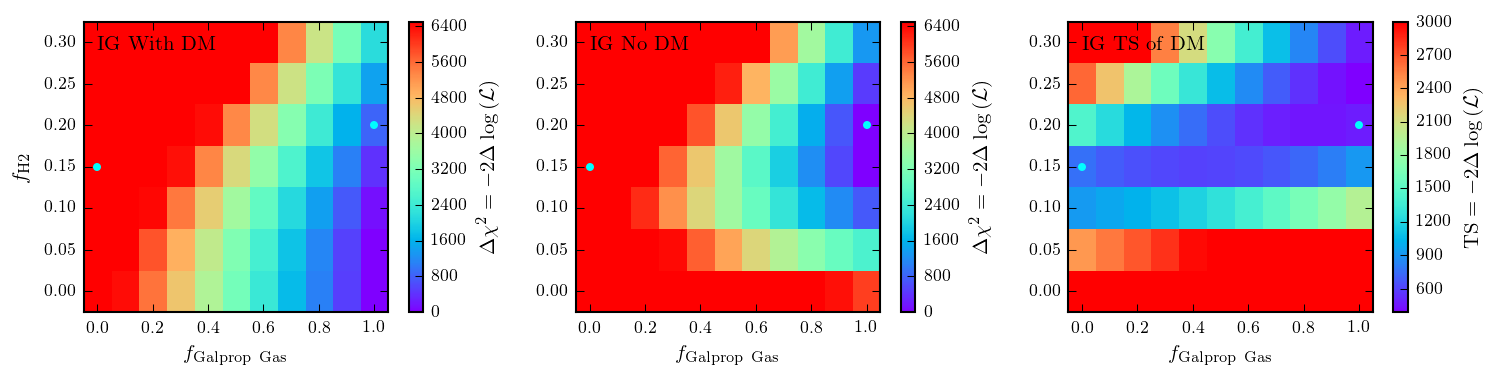

In [11]:
PlotMixtures()
#plt.subplots_adjust(wspacing=0.1)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/fH2_fgalgas_plane_P8.pdf', bbox_inches='tight')

#Residuals as $f_{H2}$ is increased

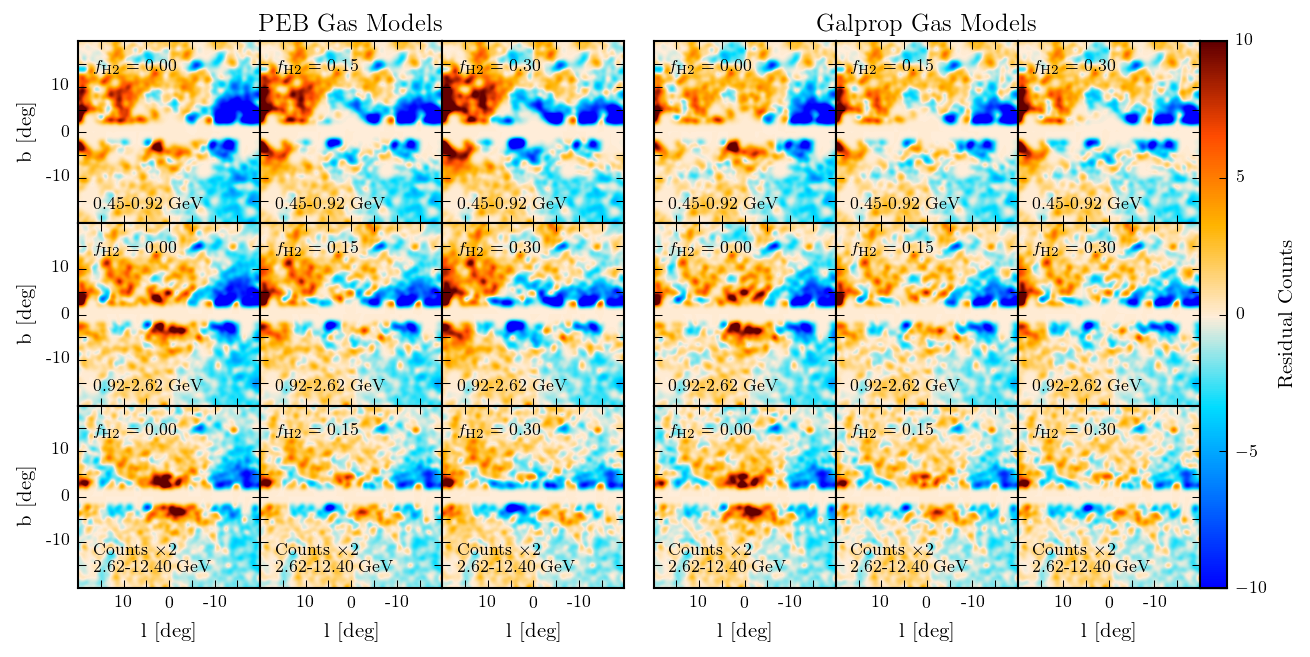

In [60]:
import h5py
import healpy
import sys
sys.path.append('../')
import Analysis
from scipy import ndimage




from matplotlib.colors import ListedColormap
import numpy as np
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
#colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap



A = Analysis.Analysis() 
mask = A.GenSquareMask(l_range=[-20,20], b_range=[-20,20], plane_mask=2)
psc_weights = A.CalculatePixelWeights(diffuse_model='../fermi_diffuse_'+A.tag+'.npy',psc_model='../PSC_3FGL_with_ext.npy',alpha_psc=5., f_psc=0.1)

def PlotResiduals(model, energy_range, text, grid):
    # Open the file and load the fit results of interest.
    h = h5py.File('../mod_c/mod_o_%i_XCO_P8_stripped.hdf5'%model)
    residual = h['/fit_results/GC_no_dm/residual'][...]
    E = h['/fit_results/GC_no_dm'].attrs['energies']
    
    E_bin_1, E_bin_2 = np.argmin(np.abs(energy_range[0]-E)), np.argmin(np.abs(energy_range[1]-E))
    plt.figure(2)
    
    # TESTING 
#     print residual.shape
#     print residual[E_bin_1:E_bin_2].shape
#     print A.psc_weights[E_bin_1:E_bin_2].shape
    
    np.sum(residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*mask
    #-----------------------------------
    
    m = healpy.cartview(np.sum(residual[E_bin_1:E_bin_2]*A.psc_weights[E_bin_1:E_bin_2], axis=0)*mask,latra=[-20,20], lonra=[-20,20],xsize=320, return_projected_map=True, hold=True, cbar=False)
    real_energies=(E[E_bin_1]/1e3,E[E_bin_2]/1e3) 
    plt.clf()
    plt.figure(1)
    multiplier = 1
    if energy_range[0] > 2e3: 
        multiplier = 2 
        grid.text(.08,.19, r'Counts $\times 2$', transform=grid.transAxes, fontsize=8,)
    im = grid.imshow(ndimage.gaussian_filter(m*multiplier,4), origin='lower', extent=[20,-20,-20,20], cmap=cmap, vmin=-10,vmax=10)
    #plt.imshow(ndimage.gaussian_filter(m,4), origin='lower', extent=[20,-20,-20,20], cmap='bwr', vmin=-3*np.std(m),vmax=3*np.std(m))
    
    grid.xaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.yaxis.set_ticks([-15,-10,-5,0,5,10,15])
    grid.xaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.yaxis.set_ticklabels(["",-10,"",0,"",10,""])
    grid.text(.08,.08,'%1.2f-%1.2f GeV'%(A.bin_edges[E_bin_1]/1e3,A.bin_edges[E_bin_2+1]/1e3), transform=grid.transAxes, fontsize=8)
    grid.text(.08,.82, text, transform=grid.transAxes, fontsize=8)
    #plt.colorbar(label='Residual Counts')
    return im 
    

from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(1, figsize=(9.5,4.7))

grid = AxesGrid(fig, 121, # similar to subplot(142)
                        nrows_ncols = (3, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode=None,)
grid2 = AxesGrid(fig, 122, # similar to subplot(142)
                        nrows_ncols = (3, 3),
                        axes_pad = 0,
                        share_all=True,
                        label_mode = "L",
                        cbar_location = "right",
                        cbar_mode='single',)


for i_E, E_range in enumerate([[.5e3, .92e3],[1e3,2.5e3], [2.8e3,10e3]]):
    for i, model in enumerate([14,17,20]):
        im = PlotResiduals(model,energy_range=E_range, text=r'$f_{\rm H2}=%1.2f$'%((model-14)*0.05), grid=grid[i_E*3+ i])
        
    for i, model in enumerate([42,45,48]):
        im = PlotResiduals(model,energy_range=E_range, text=r'$f_{\rm H2}=%1.2f$'%((model-42)*0.05),grid=grid2[i_E*3+ i])
        cbar = grid2.cbar_axes[0].colorbar(im)
    #plt.show()
    
for cax in grid2.cbar_axes[1:]:
    cax.toggle_label(False)
    

for i in [6,7,8]:
    grid[i].set_xlabel('l [deg]')
    grid2[i].set_xlabel('l [deg]')
    
for i in [0,3,6]:
    grid[i].set_ylabel('b [deg]')
    grid2[i].yaxis.set_ticklabels([])
    

cbar.solids.set_edgecolor("face")
    
fig.subplots_adjust(left=0.00, wspace=-.15)
grid[1].text(.5, 1.05, r'PEB Gas Models', horizontalalignment='center', transform=grid[1].transAxes)
grid2[1].text(.5, 1.05, r'Galprop Gas Models', horizontalalignment='center', transform=grid2[1].transAxes)

grid2.cbar_axes[0].set_ylabel(r'Residual Counts') 

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/residuals_P8.pdf', bbox_inches='tight')

#Refining the SFR model

##SNR ~ SFR ~ $\rho_{H2}^{n_s}$ if $\rho_{H2} > \rho_s$

##Vary $n_s$ and $\rho_s$



In [5]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(start, stop, text,labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False, highlight=None, row=0):
    
    if mod_k is True:
        models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    else: 
        models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_o_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    #print 'log-like, TS:', 'center_high_res_no_dm', np.sum(h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC_no_dm/'].attrs['loglike_total']-h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    #print 'log-like, TS:', 'center_high_res', np.sum(h_center_HR['/fit_results/GC/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-h_center_HR['/fit_results/GC/'].attrs['loglike_total'])
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    p7v6_LL_total = 2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = 2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    p7v6_LL_total_no_dm = 2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = 2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike_nodm.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):        
        
        
        #print h_base['/fit_results/GC/'].attrs['loglike_total']
        
        
        h = h5py.File('../mod_c/'+model)
        fit = h['/fit_results/GC'].attrs
        fit_no_dm = h['/fit_results/GC_no_dm'].attrs
        #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
        ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
        ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))

        fit_global = h['/fit_results/global'].attrs
        llg1.append(-fit_global['localfval'])
        #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
        llg2.append(-fit_global['outerfval'])
        llg3.append(-fit_global['innerfval'])
        llg4.append(llg1[-1]+llg2[-1]+llg3[-1])

        #print fit.keys()
        E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']

        plt.subplot(3,3,1+3*row)


        E_p6, spec_p6, spec_unc_p6 = pickle.load(open('../p6v11_Analysis_spectrum.pickle','rb'))

        if i==0:
            plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3, 
                         label='ModA',capthick=1, capsize=2, ls=':', marker='o', markersize=2)

        elif i%mod==0:

            if highlight is not None and i == highlight:
                plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3, 
                             label=labels[i-1],capthick=1, capsize=2, ls='-' , color='firebrick', alpha=(i+2.)/(stop-start+2), marker='o', markersize=2)
            else:
                plt.errorbar(E/1e3,(E**2*flux/1e3), 
                             label=labels[i-1],capthick=1, capsize=2, ls='-' , color='firebrick', alpha=(i+2.)/(stop-start+2))
    
    plt.subplot(3,3,1+3*row)
    plt.legend(frameon=False, fontsize=8, labelspacing=.2, borderpad=0.1)
    plt.yscale('log')
    plt.xscale('log')
    
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    
    if row==2:
        plt.xlabel(r'$\rm{E\ [GeV]}$')
    
    plt.ylim(5e-8,2e-6)
    plt.text(.03,.8, text, transform=plt.gca().transAxes, fontsize=10)
    
#     if 'spiral' in text:
#         plt.yscale('symlog')
#         plt.ylim(5e-7,2e-6)
    
#     plt.subplot(222)
#     plt.ylabel(r'$-2\Delta\ln{(\mathcal{L})}$')   
#     plt.xlabel(r'$\rm{E\ [GeV]}$')
#     plt.xscale('log')
#     plt.ylim(-50,200)
            
    plt.subplot(3,3,2+3*row)
    fh2 = np.linspace(0,.3,7)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
    
    
    
    plt.plot(fh2, ll[1:],marker='o',ls=':',color='firebrick', label='With DM',markersize=4)
    plt.plot(fh2, ll_no_dm[1:],marker='o',ls='--',color='steelblue',label='No DM',markersize=4)
    plt.xlim(-.025, 0.325)
    if row==2:
        plt.xlabel(r'$f_{\rm H2}$', fontsize=12)
    
    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    
    
    #plt.hlines(p7v6_LL_total, -1, len(labels), color='firebrick')
    plt.hlines(p6v11_LL_total, -1, len(labels), color='firebrick',linestyles=':')
    #plt.hlines(p7v6_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--')
    plt.hlines(p6v11_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--' )
    
    if start < 28:
        plt.text(.1*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total+.025*(plt.ylim()[1]-plt.ylim()[0]),'P6V11', color='firebrick', fontsize=8)
        plt.text(.1*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total_no_dm-.07*(plt.ylim()[1]-plt.ylim()[0]),'P6V11 No DM', color='steelblue', fontsize=8)
    
    
    #plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6', color='purple', fontsize=8)
    #plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total_no_dm-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6 No DM', color='purple', fontsize=8)
    
    
    
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    if start < 28:
        plt.legend(frameon=False, fontsize=8, loc=4, bbox_to_anchor=(.95, .15))
    else:
        plt.legend(frameon=False, fontsize=8, loc=1, ncol=2)
    
    plt.subplot(3,3,3+3*row)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    
    
    plt.plot(fh2, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(fh2, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(fh2, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(fh2, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    plt.xlim(-.025, 0.325)
    if row==2:
        plt.xlabel(r'$f_{\rm H2}$', fontsize=12)
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=9, ncol=4, columnspacing=.5)
    
    





# PEB gas models: Vary $n_s$ and $f_{H2}$ 

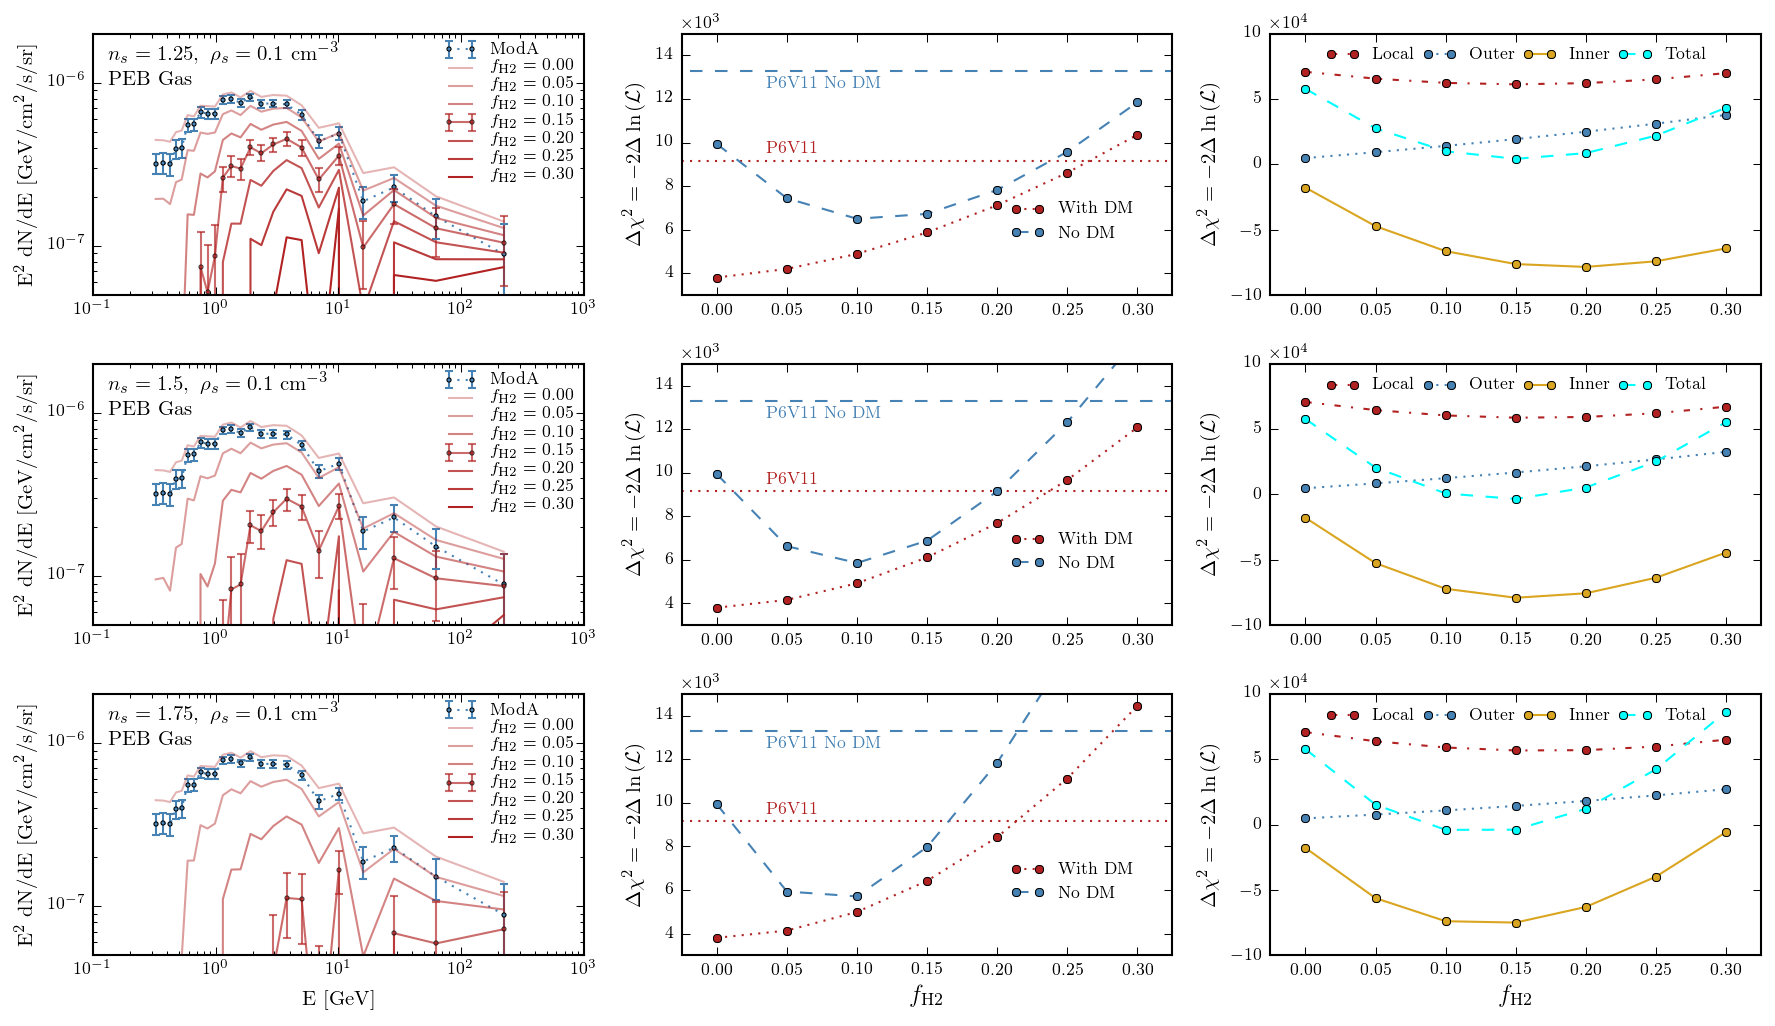

In [6]:
# plt.figure(figsize=(15,8))
# PlotSeries(start=0, stop=7, text='$n_s=1.0$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, mod_k=False, ylim=(-3000,3000))
# plt.show()

plt.figure(figsize=(12,7), dpi=10)

PlotSeries(start=7, stop=14, text=r'\noindent$n_s=1.25,\ \rho_s=0.1\ \rm  cm^{-3}\\ PEB\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(3e3,15e3), ylim_glob=(-10e4,10e4), highlight=4, row=0)
PlotSeries(start=14, stop=21, text=r'\noindent$n_s=1.5,\ \rho_s=0.1\ \rm  cm^{-3}\\ PEB\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(3e3,15e3), ylim_glob=(-10e4,10e4), highlight=4, row=1)
PlotSeries(start=21, stop=28, text=r'\noindent$n_s=1.75,\ \rho_s=0.1\ \rm  cm^{-3}\\ PEB\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(3e3,15e3), ylim_glob=(-10e4,10e4), highlight=4, row=2)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_ns_fh2_PEB_P8.pdf', bbox_inches='tight')

# Galprop gas models: Vary $n_s$ and $f_{H2}$ 

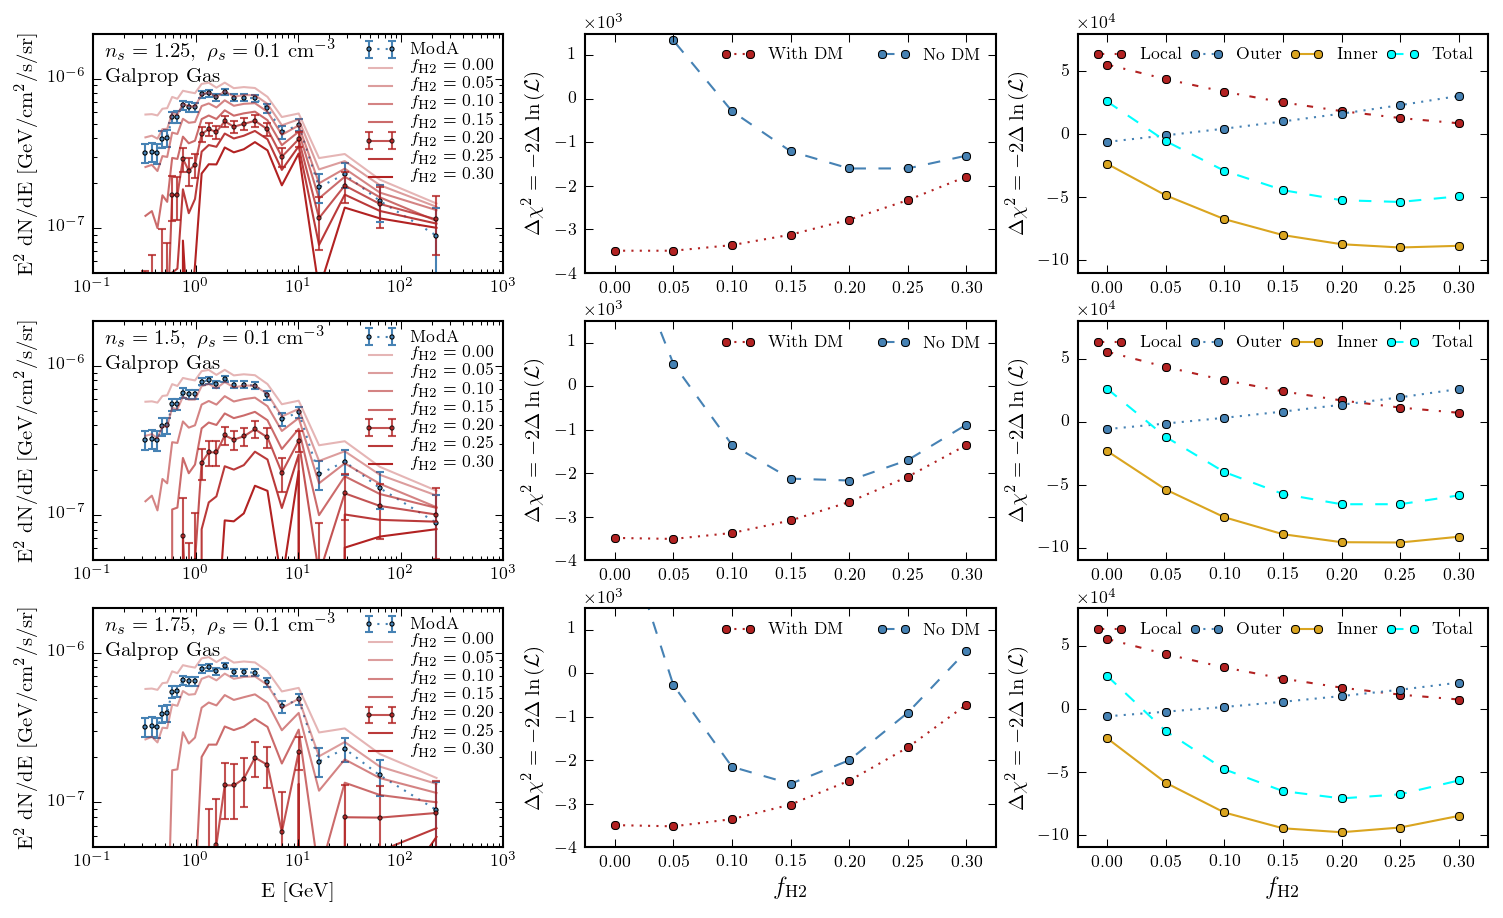

In [27]:

# PlotSeries(start=28, stop=35, text=r'$n_s=1.0,\ \rho_s=0.1\ \rm cm^{-3}$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(-1000,4000), ylim_glob=(-5e4,6e4))
# plt.show()

plt.figure(figsize=(12,7))

PlotSeries(start=35, stop=42, text=r'\noindent$n_s=1.25,\ \rho_s=0.1\ \rm  cm^{-3}\\ Galprop\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(-4000,1500), ylim_glob=(-11e4,8e4), highlight=5, row=0)
#plt.show()
PlotSeries(start=42, stop=49, text=r'\noindent$n_s=1.5,\ \rho_s=0.1\ \rm  cm^{-3}\\ Galprop\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None,ylim=(-4000,1500), ylim_glob=(-11e4,8e4), highlight=5, row=1)
#plt.show()
PlotSeries(start=49, stop=56, text=r'\noindent$n_s=1.75,\ \rho_s=0.1\ \rm  cm^{-3}\\ Galprop\ Gas$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(-4000,1500), ylim_glob=(-11e4, 8e4), highlight=5, row=2)
#plt.show()
# PlotSeries(start=63, stop=70, text='$n_s=2.0$', labels=[r'$f_{\rm H2}=%1.2f$'%i for i in np.linspace(0,.3,7)], mod=1, line=None, ylim=(-1000,4000), ylim_glob=(-4e4,6e4))
# plt.show()
plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_ns_fh2_galprop_P8.pdf', bbox_inches='tight')

In [29]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(start, stop, text,labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False):
    
    if mod_k is True:
        models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_k_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    else: 
        models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_n_%i_XCO_P8_stripped.hdf5'%i for i in range(start, stop)]
    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    #print 'log-like, TS:', 'center_high_res_no_dm', np.sum(h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC_no_dm/'].attrs['loglike_total']-h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    #print 'log-like, TS:', 'center_high_res', np.sum(h_center_HR['/fit_results/GC/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-h_center_HR['/fit_results/GC/'].attrs['loglike_total'])
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    p7v6_LL_total = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    p7v6_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike_nodm.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):        
        try:
            
            h = h5py.File('../mod_c/'+model)
            
            fit = h['/fit_results/GC'].attrs
            fit_no_dm = h['/fit_results/GC_no_dm'].attrs
            #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
            ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
            ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))
            
            fit_global = h['/fit_results/global'].attrs
            llg1.append(-fit_global['localfval'])
            #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
            llg2.append(-fit_global['outerfval'])
            llg3.append(-fit_global['innerfval'])
            llg4.append(llg1[-1]+llg2[-1]+llg3[-1])
            
            #print fit.keys()
            E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']
            
            plt.subplot(131)

            if i==0:
                plt.errorbar(E/1e3,E**2*flux/1e3,([E**2,E**2]*stat.T/1e3), 
                             label='ModA',capthick=1, capsize=2, ls=':' ,marker='o', markersize=2,color='steelblue')
            elif i%mod==0:
                if i==10:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3,
                                 label=labels[i-1],capthick=1, capsize=2, ls='-', marker='o', markersize=2)
                else:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), 
                                 label=labels[i-1],capthick=1, capsize=2, ls='-')

            plt.subplot(132)
            
#             #print h_base['/fit_results/GC/'].attrs.keys()
#             if i%mod==0:
#                 TS = 2*(h_base['/fit_results/GC/'].attrs['loglike']-fit['loglike'])
#                 plt.plot(E/1e3, TS)

        except:
            ll.append(-1e10)
            ll_no_dm.append(-1e10)
            llg1.append(-1e10)
            llg2.append(-1e10)
            llg3.append(-1e10)
            llg4.append(-1e10)
            print 'no results found for model ', model
    
    
    rho_s = np.logspace(-2,-1,10)
    
    plt.subplot(132)
    plt.plot(rho_s, ll[1:],marker='o',ls=':',color='firebrick', markersize=4, label='With DM')
    plt.plot(rho_s, ll_no_dm[1:],marker='o',ls='--',color='steelblue', markersize=4,label='No DM')
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
    
    plt.subplot(131)
    plt.legend(frameon=False, fontsize=8)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.ylim(5e-8,2e-6)
    plt.text(.05,.8, text, transform=plt.gca().transAxes, fontsize=9)
    
#     if 'spiral' in text:
#         plt.yscale('symlog')
#         plt.ylim(5e-7,2e-6)
    
#     plt.subplot(222)
#     plt.ylabel(r'$-2\Delta\ln{(\mathcal{L})}$')   
#     plt.xlabel(r'$\rm{E\ [GeV]}$')
#     plt.xscale('log')
#     plt.ylim(-50,200)
            
    plt.subplot(132)
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    plt.xlim(10**-2.1,10**-.9)
    plt.xscale('log')
    plt.xlabel(r'$\rho_s\ [\rm cm^{-3}]$')
    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    
#     plt.hlines(p7v6_LL_total, -1, len(labels), color='firebrick')
#     plt.hlines(p6v11_LL_total, -1, len(labels), color='firebrick')
#     plt.hlines(p7v6_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--')
#     plt.hlines(p6v11_LL_total_no_dm, -1, len(labels), color='steelblue', linestyles='--' )
#     plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total-.06*(plt.ylim()[1]-plt.ylim()[0]),'P6V11', color='purple', fontsize=8)
#     plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6', color='purple', fontsize=8)
#     plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p6v11_LL_total_no_dm-.06*(plt.ylim()[1]-plt.ylim()[0]),'P6V11 No DM', color='purple', fontsize=8)
#     plt.text(.05*(plt.xlim()[1]-plt.xlim()[0]), p7v6_LL_total_no_dm-.06*(plt.ylim()[1]-plt.ylim()[0]),'P7V6 No DM', color='purple', fontsize=8)
               
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=1)
    
    plt.subplot(133)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    plt.plot(rho_s, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(rho_s, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(rho_s, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(rho_s, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    
    plt.xlim(10**-2.1,10**-.9)
    plt.xscale('log')
    plt.xlabel(r'$\rho_s\ [\rm cm^{-3}]$')
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2=-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=9, ncol=2,columnspacing=1)


#Vary SFR cuttoff density $\rho_s$ (in units of $n_H/cm^{-3}$)

##Low sensitivity observed but higher values of cutoff preferred in all global fitting regions and by NO DM GC analysis.  Mild preference for DM to have low threshold. Values around 0.1 are also observed to be better in simulations.

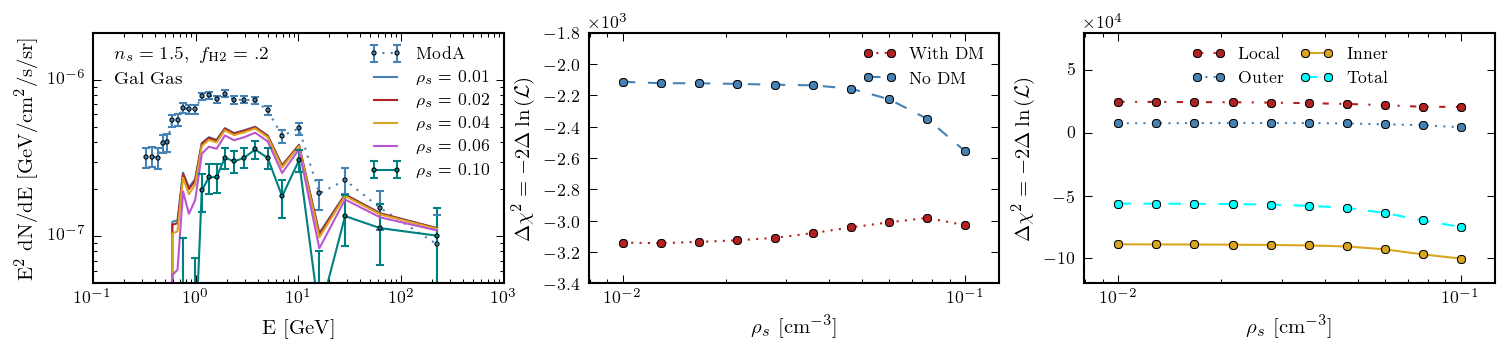

In [31]:
plt.figure(figsize=(10,2.3))

PlotSeries(start=0, stop=10, text=r'\noindent $n_s=1.5,\ f_{\rm H2 }=.2$\\  ~~~ Gal Gas', labels=[r'$\rho_s=\ $%1.2f'%i for i in np.logspace(-2,-1,10)], mod=2, ylim=(-3.4e3,-1.8e3), ylim_glob=(-12e4,8e4))
plt.tight_layout(pad=0.4, w_pad=-.2, h_pad=.4)
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_threshold_P8.pdf', bbox_inches='tight')

# Cosmic Ray flux as a function of galactic radius (along l.o.s. to GC) 

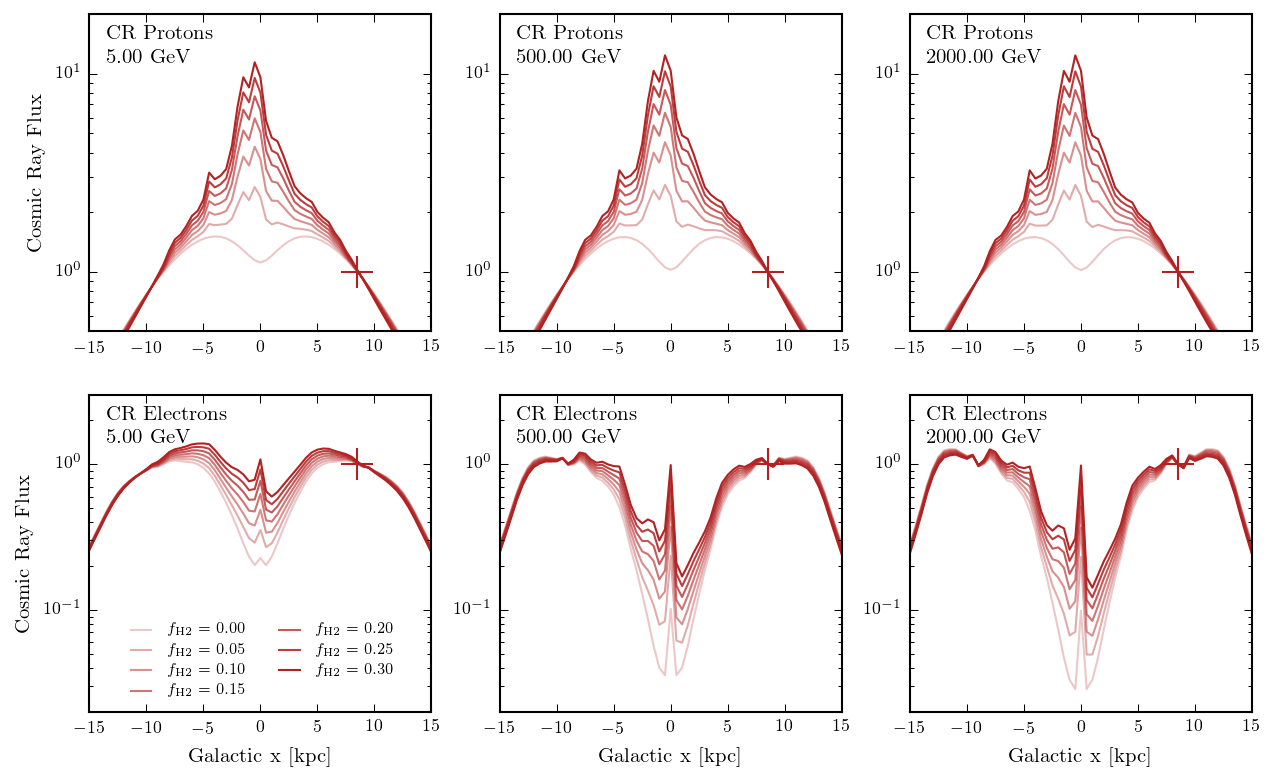

In [150]:
def GetGalpropNuclei(fits,A,Z,R=8.5):
    """
    Given a galprop 3d nuclear file (non-full), return the energy and spectrum.
    
    :param fits: path to the nuclear data fits file
    :param A: Atomic number of desired nucleus  
    :param Z: Atomic charge of desired nucelus.  All species meeting A,Z will be summed
    :param R: The desired radius to evaluate the spectrum. Linearly interpolated over grid
    :returns energies, spectrum: energies in GeV, spectrum in (GeV/nuc)^2 (m^2 sr s GeV/nuc)^-1 
    """
    # open the fits file
    hdu = pyfits.open(fits)
    
    hdr = hdu[0].header
    
    # Build list of radii and energies based on header keywords.
    r_list = np.linspace(hdr['CRVAL1'],hdr['CRVAL1']+(hdr['NAXIS1']-1)*hdr['CDELT1'],hdr['NAXIS1'])
    energies = 10.**np.linspace(hdr['CRVAL3'],hdr['CRVAL3']+(hdr['NAXIS3']-1)*hdr['CDELT3'],hdr['NAXIS3'])
    
    # Build a list of the nuclei
    A_list, Z_list = [], []
    for nucIndex in range(hdr['NAXIS4']):
        nucString = ('%.3f' % ((nucIndex+1)/1000.))[-3:]
        A_list.append(hdr['NUCA'+nucString])
        Z_list.append(hdr['NUCZ'+nucString])
        
    A_list = np.array(A_list)
    Z_list = np.array(Z_list)
    
    z_idx = int(np.abs(hdr['CRVAL2'])/float(hdr['CDELT2']))
    
    
    # Linearly interpolate spectra in radius.
    i_r2 = np.argmax(r_list>R) # finds the first element at r>R
    i_r1 = i_r2-1 # finds the next smallest radius.
    dr = r_list[i_r2]-r_list[i_r1]
    w1 = (r_list[i_r2]-R)/dr # weight for spectrum i_r1
    w2 = 1.-w1 # weight for spectrum i_r2
    
    
    master = np.zeros(hdu[0].shape[1])
    # Find which indices contain A,Z requested.  Could be more than one since primary and secondary are specified. 
    idx = np.where((A_list==A) & (Z_list==Z))[0]
    
    if len(idx)==0:
        raise Exception('No nuclei found with A,Z='+str(A)+','+str(Z))
    for i in idx:
        master += w1*hdu[0].data[i,:,z_idx,i_r1]
        master += w2*hdu[0].data[i,:,z_idx,i_r2]
  
    return energies/1e3, master*1e4/energies**2*1e3


def GetCRProfile(model, energy, A, Z ):
    ebin = np.argmin(np.abs(GetGalpropNuclei(model, A, Z, R=0)[0]-energy))
    r_list = np.linspace(-20,20,81) 
    profile = np.array([GetGalpropNuclei(model, A, Z, R=r)[1][ebin] for r in r_list])
    return r_list, profile



def PlotCRProfile(energy, models,A,Z ):
    '''
    Energy in GeV
    '''
    
    E, flux_0 = GetGalpropNuclei('../mod_c/nuclei_54_mod_m_%i.gz'%models[0], A=A, Z=Z, R=8.5)
    ebin = np.argmin(np.abs(E-energy))
    flux_0 = flux_0[ebin]
    
    labels = [r'$f_{\rm H2}=%1.2f$'%(np.linspace(0,.3,7)[i]) for i in range(7)]
    
    for i_mod, mod in enumerate(models):
        r, flux = GetCRProfile(model='../mod_c/nuclei_54_mod_m_%i.gz'%mod, energy=energy, A=A, Z=Z) 
        plt.plot(r,flux/flux_0, label=labels[i_mod], color='firebrick', alpha=(i_mod+2)/8.)
        
    
    
    plt.yscale('log')
    plt.text(.05,.85, r'$%1.2f$\ GeV'%energy, transform=plt.gca().transAxes, fontsize=10)
    
    if A==1:
        plt.text(.05,.92, 'CR Protons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(5e-1,2e1)
        
    if A==0:
        plt.text(.05,.92, 'CR Electrons', transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(-15,15)
        plt.ylim(2e-2,3e0)
        plt.xlabel('Galactic x [kpc]')
    plt.scatter(8.5,1, marker='+', s=250, color='firebrick')
    
    

plt.figure(figsize=(10,6))
models = range(49,56)
plt.subplot(2,3,1)
PlotCRProfile(energy=5, models=models, A=1, Z=1)
plt.ylabel('Cosmic Ray Flux')
plt.subplot(2,3,2)
PlotCRProfile(energy=500, models=models, A=1, Z=1)
plt.subplot(2,3,3)
PlotCRProfile(energy=2000, models=models, A=1, Z=1)


plt.subplot(2,3,4)
PlotCRProfile(energy=5, models=models, A=0, Z=1)
plt.legend(frameon=False, fontsize=7, ncol=2, loc=8)
plt.ylabel('Cosmic Ray Flux')
plt.subplot(2,3,5)
PlotCRProfile(energy=500, models=models, A=0, Z=1)
plt.subplot(2,3,6)
PlotCRProfile(energy=2000, models=models, A=0, Z=1)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/CR_density.pdf', bbox_inches='tight')


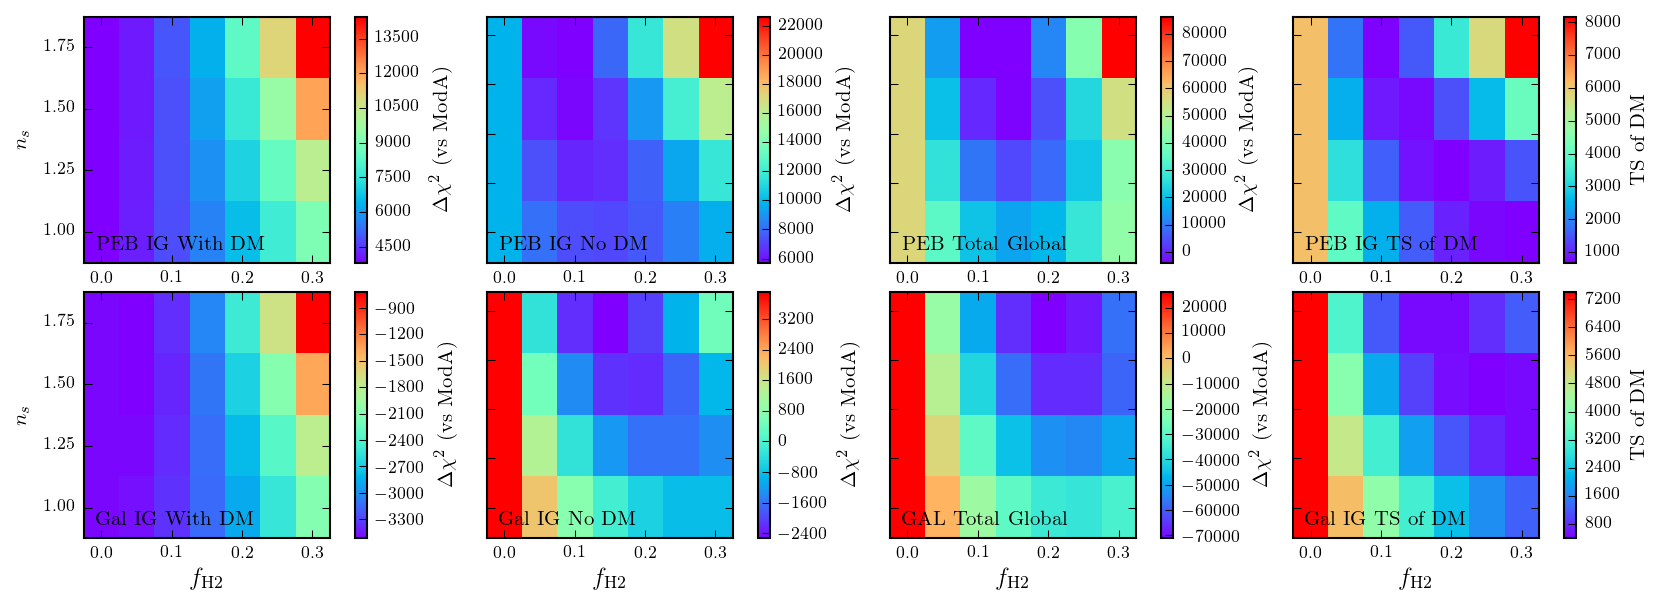

In [62]:
import h5py
def GetLogLike(model):
    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    h = h5py.File('../mod_c/'+model)        
    fit = h['/fit_results/GC'].attrs
    fit_no_dm = h['/fit_results/GC_no_dm'].attrs
    #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
    GC = 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
    GC_no_dm = 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total'])

    fit_global = h['/fit_results/global'].attrs
    local = -2*(fit_global['localfval']-h_base['/fit_results/global'].attrs['localfval'])
    outer = -2*(fit_global['outerfval']-h_base['/fit_results/global'].attrs['outerfval'])
    inner = -2*(fit_global['innerfval']-h_base['/fit_results/global'].attrs['innerfval'])
    total = inner+outer+local
    
    return GC, GC_no_dm, inner, outer, local, total

arr_GC = np.zeros((2,4,7))
arr_GC_no_dm = np.zeros((2,4,7))
arr_GC_TS = np.zeros((2,4,7))
arr_global_inner = np.zeros((2,4,7))
arr_global_total = np.zeros((2,4,7))

for i_ns in range(4):
    for i_fh2 in range(7):
        GC, GC_no_dm, inner, outer, local, total = GetLogLike('mod_o_%i_XCO_P8_stripped.hdf5'%(7*i_ns+i_fh2))
        arr_GC[0, i_ns,i_fh2] = GC
        arr_GC_no_dm[0, i_ns,i_fh2] = GC_no_dm
        arr_global_inner[0, i_ns,i_fh2] = inner
        arr_global_total[0, i_ns,i_fh2] = total
        arr_GC_TS[0, i_ns,i_fh2] = GC-GC_no_dm
        
        GC, GC_no_dm, inner, outer, local, total = GetLogLike('mod_o_%i_XCO_P8_stripped.hdf5'%(28+7*i_ns+i_fh2))
        arr_GC[1 ,i_ns,i_fh2] = GC
        arr_GC_no_dm[1,i_ns,i_fh2] = GC_no_dm
        arr_global_inner[1,i_ns,i_fh2] = inner
        arr_global_total[1,i_ns,i_fh2] = total
        arr_GC_TS[1,i_ns,i_fh2] = GC-GC_no_dm
        
        
def PlotArr(arr, text, sp):
    plt.subplot(2,4,sp)
    if 'TS' in text:
        plt.imshow(arr, origin='lower', cmap='rainbow', interpolation='nearest', extent=[-.025,.325,.875,1.875], aspect=.35)
        plt.colorbar(label=r'TS of DM')
    else: 
        plt.imshow(-arr, origin='lower', cmap='rainbow', interpolation='nearest', extent=[-.025,.325,.875,1.875], aspect=.35)
        if sp in [4,8]:
            cbar = plt.colorbar(label=r'$\Delta \chi^2$')
            
        else:
            cbar = plt.colorbar(label=r'$\Delta \chi^2\  (\rm vs\ ModA)$')
        cbar.solids.set_edgecolor("face")
    #if sp in [2,4]:
    #    plt.colorbar(label=r'$\Delta \chi^2\  (\rm vs\ ModA)$')
    if sp in [1,5,]:
        plt.yticks([1,1.25,1.5,1.75])
    else: 
        plt.gca().yaxis.set_ticklabels([])
        #plt.gca().tick_labelsytick_labels([])
    plt.xticks([0,.1,.2,.3])
    if sp >4:
        plt.xlabel(r'$f_{\rm H2}$', fontsize =12)
    if sp in [1,5]:
        plt.ylabel(r'$n_s$')
    plt.text(.05,.05, text, transform=plt.gca().transAxes, fontsize=10)

plt.figure(figsize=(12,4))
PlotArr(arr_GC[0], 'PEB IG With DM', 1)
PlotArr(arr_GC_no_dm[0], 'PEB IG No DM', 2)
PlotArr(arr_GC_TS[0], 'PEB IG TS of DM', 4)
PlotArr(arr_global_total[0], 'PEB Total Global', 3)


PlotArr(arr_GC[1], 'Gal IG With DM', 1+4)
PlotArr(arr_GC_no_dm[1], 'Gal IG No DM', 2+4)
PlotArr(arr_GC_TS[1], 'Gal IG TS of DM', 4+4)
PlotArr(arr_global_total[1], 'GAL Total Global', 3+4)

plt.tight_layout(pad=0.4, w_pad=-5, h_pad=.2)
#plt.savefig('./summary.pdf', bbox_inches='tight')

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots//ns_fh2_plane_P8.pdf', bbox_inches='tight')

In [5]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(model_list, text, labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False):
    
    models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_o_46_%i_XCO_P8_limit_inner_stripped.hdf5'%i for i in model_list]
    
    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    #print 'log-like, TS:', 'center_high_res_no_dm', np.sum(h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC_no_dm/'].attrs['loglike_total']-h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    #print 'log-like, TS:', 'center_high_res', np.sum(h_center_HR['/fit_results/GC/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-h_center_HR['/fit_results/GC/'].attrs['loglike_total'])
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    p7v6_LL_total = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    p7v6_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):                    
            h = h5py.File('../mod_c/'+model)
            
            fit = h['/fit_results/GC'].attrs
            fit_no_dm = h['/fit_results/GC_no_dm'].attrs
            #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
            ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
            ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))
            
            
            fit_global = h['/fit_results/global'].attrs
            
            #vals = X_CO_interp(rings)*fit_global['global_XCO']
            #print fit_global['global_XCO']
            
            llg1.append(-fit_global['localfval'])
            #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
            llg2.append(-fit_global['outerfval'])
            llg3.append(-fit_global['innerfval'])
            llg4.append(llg1[-1]+llg2[-1]+llg3[-1])
            
            E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']
            
            plt.subplot(131)

            if i==0:
                plt.errorbar(E/1e3,E**2*flux/1e3,([E**2,E**2]*stat.T/1e3), 
                             label='ModA',capthick=1, capsize=2, ls=':' ,marker='o', markersize=2,color='steelblue')
            elif i%mod==0:
                if i==10:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3,
                                 label=labels[i-1],capthick=1, capsize=2, ls='-', marker='o', markersize=2)
                else:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), 
                                 label=labels[i-1],capthick=1, capsize=2, ls='-')

            plt.subplot(132)
            
    
    rho_s = [(i/10.) for i in range(0,11,1)]
    
    plt.subplot(132)
    plt.plot(rho_s, ll[1:],marker='o',ls=':',color='firebrick', markersize=4, label='With DM')
    plt.plot(rho_s, ll_no_dm[1:],marker='o',ls='--',color='steelblue', markersize=4,label='No DM')
    
    plt.subplot(131)
    plt.legend(frameon=False, fontsize=8)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.ylim(5e-8,2e-6)
    plt.text(.05,.8, text, transform=plt.gca().transAxes, fontsize=9)

            
    plt.subplot(132)
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    #plt.xlim(10**-2.1,10**-.9)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
               
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2)
    
    plt.subplot(133)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    plt.plot(rho_s, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(rho_s, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(rho_s, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(rho_s, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    
    #plt.xlim(0,)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2, ncol=2,columnspacing=1)


# Increasing X_CO of the central ring (r<1.8).  In the fits, the preferred value is zero, but below we show that it is compatible with previous estimates of X_CO in the GC and doesn't effect the GCE flux anyway.  Should perhaps double check the GC analysis. 

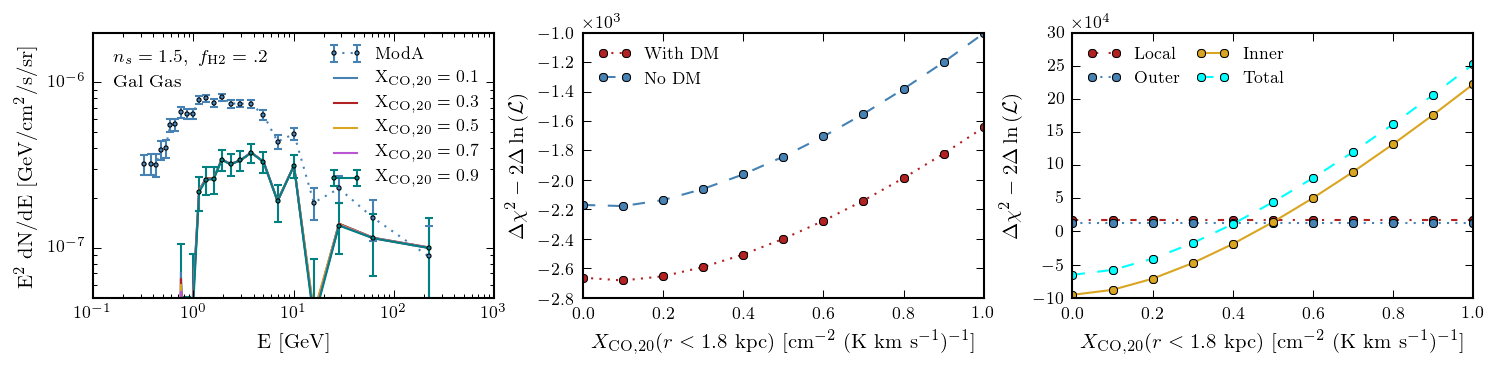

In [6]:
plt.figure(figsize=(10,2.4))

PlotSeries(range(0,11,1), text=r'\noindent $n_s=1.5,\ f_{\rm H2 }=.2$\\  ~~~ Gal Gas', labels=[r'$\rm X_{\rm CO,20}=\ $%1.1f'%(i/10.) for i in range(0,11,1)], mod=2, )#ylim=(2.2e3,3.5e3), ylim_glob=(-6e4,.6e5))
plt.tight_layout(pad=0.4, w_pad=-.2, h_pad=.4)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_XCO_P8.pdf', bbox_inches='tight')

#Radial wind

In [3]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(model_list, text, labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False):
    
    models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_q_%i_XCO_P8_stripped.hdf5'%i for i in model_list]

    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    #print 'log-like, TS:', 'center_high_res_no_dm', np.sum(h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC_no_dm/'].attrs['loglike_total']-h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    #print 'log-like, TS:', 'center_high_res', np.sum(h_center_HR['/fit_results/GC/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-h_center_HR['/fit_results/GC/'].attrs['loglike_total'])
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    p7v6_LL_total = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    p7v6_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):               
            print model
            h = h5py.File('../mod_c/'+model)
            
            fit = h['/fit_results/GC'].attrs
            fit_no_dm = h['/fit_results/GC_no_dm'].attrs
            #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
            ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
            ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))
            
            
            fit_global = h['/fit_results/global'].attrs
            
            #vals = X_CO_interp(rings)*fit_global['global_XCO']
            #print fit_global['global_XCO']
            
            llg1.append(-fit_global['localfval'])
            #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
            llg2.append(-fit_global['outerfval'])
            llg3.append(-fit_global['innerfval'])
            llg4.append(llg1[-1]+llg2[-1]+llg3[-1])
            
            E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']
            
            plt.subplot(131)

            if i==0:
                plt.errorbar(E/1e3,E**2*flux/1e3,([E**2,E**2]*stat.T/1e3), 
                             label='ModA',capthick=1, capsize=2, ls=':' ,marker='o', markersize=2,color='steelblue')
            elif i%mod==0:
                if i==10:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3,
                                 label=labels[i-1],capthick=1, capsize=2, ls='-', marker='o', markersize=2)
                else:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), 
                                 label=labels[i-1],capthick=1, capsize=2, ls='-')

            plt.subplot(132)
            
    
    rho_s = np.linspace(0,1000,11)
    
    plt.subplot(132)
    plt.plot(rho_s, ll[1:],marker='o',ls=':',color='firebrick', markersize=4, label='With DM')
    plt.plot(rho_s, ll_no_dm[1:],marker='o',ls='--',color='steelblue', markersize=4,label='No DM')
    
    plt.subplot(131)
    plt.legend(frameon=False, fontsize=8)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.ylim(5e-8,2e-6)
    plt.text(.05,.8, text, transform=plt.gca().transAxes, fontsize=9)

            
    plt.subplot(132)
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    #plt.xlim(10**-2.1,10**-.9)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
               
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2)
    
    plt.subplot(133)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    plt.plot(rho_s, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(rho_s, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(rho_s, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(rho_s, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    
    #plt.xlim(0,)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2, ncol=2,columnspacing=1)


KeyError: "Unable to open object (Object 'gc' doesn't exist)"

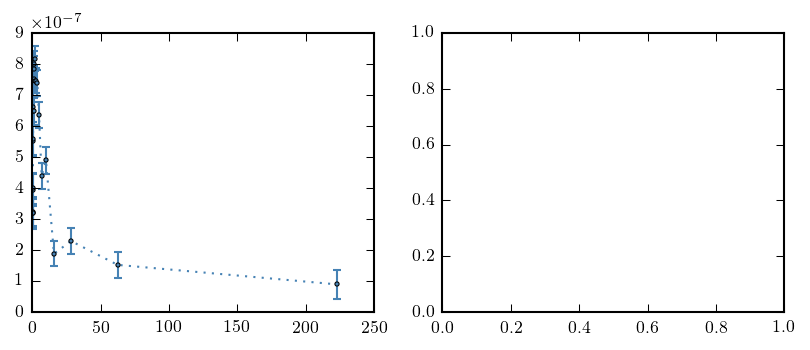

In [4]:
plt.figure(figsize=(10,2.4))

PlotSeries(range(0,11), text=r'\noindent $n_s=1.5,\ f_{\rm H2 }=.2$\\  ~~~ Gal Gas', labels=[r'$\rm v_{\rm wind}=\ $%1.1f'%(i/10.) for i in range(0,11)], mod=1, )#ylim=(2.2e3,3.5e3), ylim_glob=(-6e4,.6e5))
plt.tight_layout(pad=0.4, w_pad=-.2, h_pad=.4)

#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_XCO_P8.pdf', bbox_inches='tight')

#Scan $\delta$

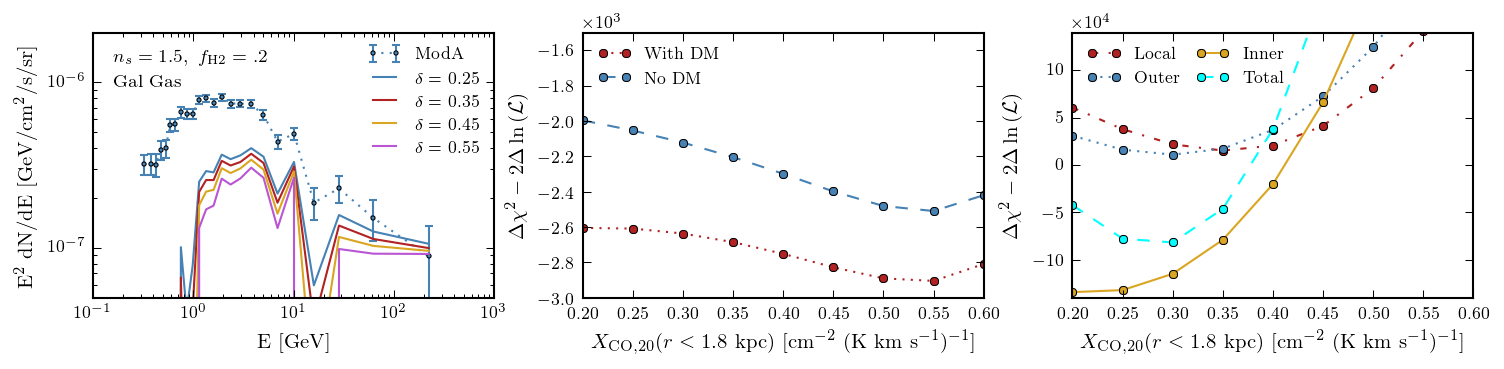

In [23]:
import cPickle as pickle
import h5py



from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag


def PlotSeries(model_list, text, labels, ylim=None, mod=1, ylim_glob=None, line=None, mod_k=False):
    
    models = ['../mod_c/base_2D_XCO_P8_stripped.hdf5'] + ['mod_r_%i_XCO_P8_stripped.hdf5'%i for i in model_list]

    h_base = h5py.File('../mod_c/base_2D_XCO_P8_stripped.hdf5')
    
    #print 'log-like, TS:', 'center_high_res_no_dm', np.sum(h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC_no_dm/'].attrs['loglike_total']-h_center_HR['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    #print 'log-like, TS:', 'center_high_res', np.sum(h_center_HR['/fit_results/GC/'].attrs['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-h_center_HR['/fit_results/GC/'].attrs['loglike_total'])
    
    fits = []
    ll, ll_no_dm = [], []
    llg1, llg2, llg3, llg4 = [],[],[],[]
    
    p7v6_LL_total = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    p6v11_LL_total = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC/'].attrs['loglike_total'])
    
    p7v6_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p7v6_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    p6v11_LL_total_no_dm = -2*(np.sum(pickle.load(open('../p6v11_Analysis_loglike.pickle','rb')))-h_base['/fit_results/GC_no_dm/'].attrs['loglike_total'])
    
    for i, model in enumerate(models):               
            #print model
            h = h5py.File('../mod_c/'+model)
            
            fit = h['/fit_results/GC'].attrs
            fit_no_dm = h['/fit_results/GC_no_dm'].attrs
            #print 'log-like, TS:', models[i], np.sum(fit['loglike_total']), 2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total'])
            ll.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit['loglike_total']))
            ll_no_dm.append(-2*(h_base['/fit_results/GC/'].attrs['loglike_total']-fit_no_dm['loglike_total']))
            
            
            fit_global = h['/fit_results/global'].attrs
            
            #vals = X_CO_interp(rings)*fit_global['global_XCO']
            #print fit_global['global_XCO']
            
            llg1.append(-fit_global['localfval'])
            #print fit_global['localfval'], fit_global['outerfval'], fit_global['innerfval']
            llg2.append(-fit_global['outerfval'])
            llg3.append(-fit_global['innerfval'])
            llg4.append(llg1[-1]+llg2[-1]+llg3[-1])
            
            E, flux, stat = fit['energies'], fit['flux_DM'], fit['fluxunc_DM']
            
            plt.subplot(131)

            if i==0:
                plt.errorbar(E/1e3,E**2*flux/1e3,([E**2,E**2]*stat.T/1e3), 
                             label='ModA',capthick=1, capsize=2, ls=':' ,marker='o', markersize=2,color='steelblue')
            elif i%mod==0:
                if i==10:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), E**2*stat.T/1e3,
                                 label=labels[i-1],capthick=1, capsize=2, ls='-', marker='o', markersize=2)
                else:
                    plt.errorbar(E/1e3,(E**2*flux/1e3), 
                                 label=labels[i-1],capthick=1, capsize=2, ls='-')

            plt.subplot(132)
            
    
    rho_s = np.linspace(.2,.7, 11)[:-2]
    
    plt.subplot(132)
    plt.plot(rho_s, ll[1:],marker='o',ls=':',color='firebrick', markersize=4, label='With DM')
    plt.plot(rho_s, ll_no_dm[1:],marker='o',ls='--',color='steelblue', markersize=4,label='No DM')
    
    plt.subplot(131)
    plt.legend(frameon=False, fontsize=8)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    plt.xlabel(r'$\rm{E\ [GeV]}$')
    plt.ylim(5e-8,2e-6)
    plt.text(.05,.8, text, transform=plt.gca().transAxes, fontsize=9)

            
    plt.subplot(132)
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    #plt.xlim(10**-2.1,10**-.9)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim is not None:
        plt.ylim(ylim)
        
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line, yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(3))
               
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2)
    
    plt.subplot(133)
    plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(4))
    
    # ------------------------------------------------
    # Global fitting plot
    # ------------------------------------------------
    plt.plot(rho_s, -2*(llg1[1:]-llg1[0]),marker='o',ls='-.', markersize=4, color='firebrick', label='Local')
    plt.plot(rho_s, -2*(llg2[1:]-llg2[0]),marker='o',ls=':', markersize=4,color='steelblue', label='Outer')
    plt.plot(rho_s, -2*(llg3[1:]-llg3[0]),marker='o',ls='-', markersize=4,color='goldenrod', label='Inner')
    plt.plot(rho_s, -2*(llg4[1:]-llg4[0]),marker='o',ls='--', markersize=4,color='cyan', label='Total')
    #plt.xticks(range(len(labels)), labels, rotation='vertical')
    
    #plt.xlim(0,)
    #plt.xscale('log')
    plt.xlabel(r'$X_{\rm CO,20}(r<1.8\ \rm kpc)\ [cm^{-2}~ (K~ km~ s^{-1})^{-1}]$')
    if ylim_glob is not None:
        plt.ylim(ylim_glob)
    if line is not None:
        yl = plt.ylim()
        plt.vlines(line,yl[0],yl[1],color='k',alpha=.25, linestyle='--')
    plt.ylabel(r'$\Delta\chi^2-2\Delta\ln{(\mathcal{L})}$') 
    plt.legend(frameon=False, fontsize=8, loc=2, ncol=2,columnspacing=1)

plt.figure(figsize=(10,2.4))

PlotSeries(range(0,9), text=r'\noindent $n_s=1.5,\ f_{\rm H2 }=.2$\\  ~~~ Gal Gas', labels=[r'$\rm \delta=\ $%1.2f'%i for i in np.linspace(.2,.7, 11)[:-2]], mod=2, ylim=(-3e3,-1.5e3), ylim_glob=(-14e4,1.4e5))
plt.tight_layout(pad=0.4, w_pad=-.2, h_pad=.4)

plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/vary_delta_P8.pdf', bbox_inches='tight')
    